In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/energy_time_60hr_most.root")
f.ls()

TFile**		./data/energy_time_60hr_most.root	
 TFile*		./data/energy_time_60hr_most.root	
  KEY: TCanvas	c1;1	c1


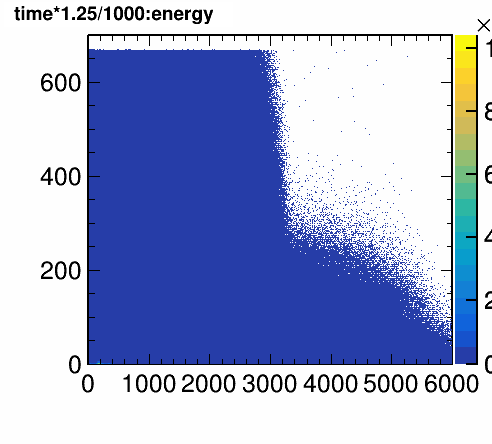

In [3]:
c1 = f.Get("c1")
c1.Draw()

In [4]:
h = c1.GetPrimitive("hist").Clone()
h.SetDirectory(0)
print(h)

<ROOT.TH2F object ("hist") at 0x7fffe74c0590>


In [5]:
c1.GetListOfPrimitives().Print()

Collection name='TList', class='TList', size=3
 TFrame  X1=0.000000 Y1=0.000000 X2=6000.000000 Y2=700.000000 Width=2 FillColor=10 FillStyle=1001
 TH1.Print Name  = hist, Entries= -2147483648, Total sum= 7.90641e+09
 TPaveText  X1=-1378.378419 Y1=718.037107 X2=2396.469016 Y2=770.945948 Width=2 FillStyle=1001
 Collection name='TList', class='TList', size=1
  Text  X=0.000000 Y=0.000000 Text=time*1.25/1000:energy Font=0 Size=0.000000 Color=0 Align=0


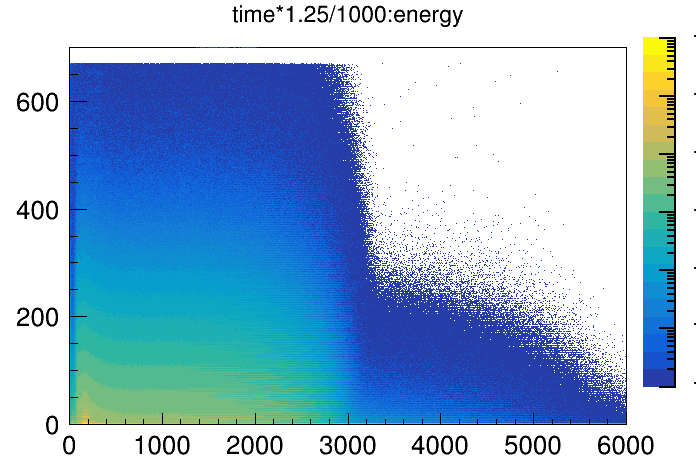

In [6]:
c2 = r.TCanvas()
h.Draw("COLZ")
c2.SetLogz()
c2.Draw()

f = r.TFile("./data/gm2offline_ana.root")
f.cd("farline/calo1")
#f.ls()

c = r.TCanvas()
evt = f.Get("farline").Get("calo1").Get("energy_vs_time").Clone()
for calo in range(2,25):
    evt2 = f.Get("farline").Get("calo"+str(calo)).Get("energy_vs_time").Clone()
    evt.Add(evt2,1)
evt.Draw("colz")
c.SetLogz()
c.Draw()

evt.Reset()
evt.Add(h,1)

In [7]:
evt = h.Clone()

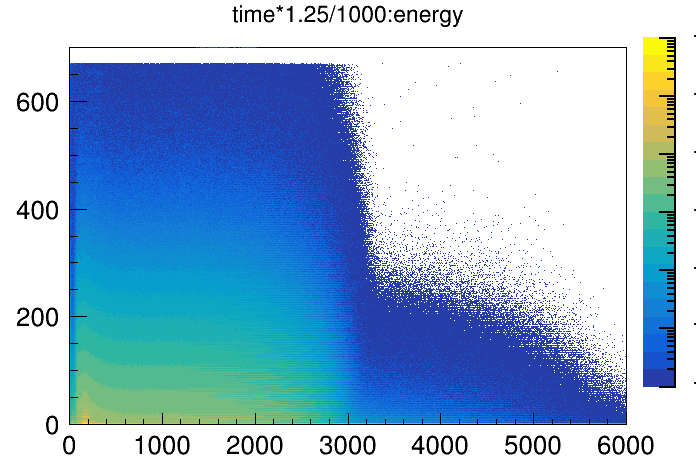

In [8]:
c2 = r.TCanvas()
evt.Draw("COLZ")
c2.SetLogz()
c2.Draw()

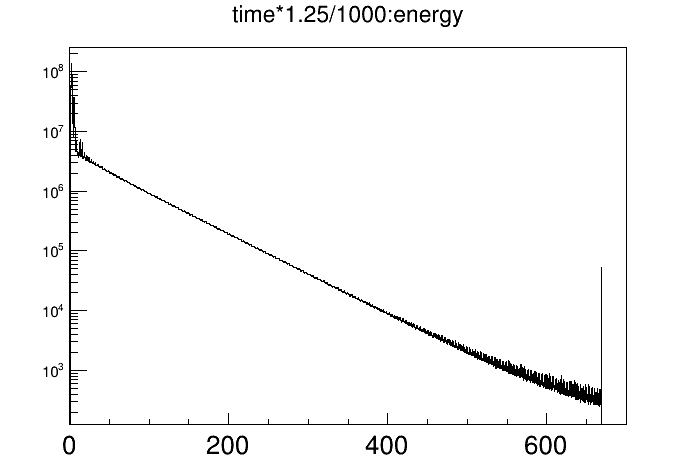

In [9]:
c2 = r.TCanvas()
evt.GetXaxis().SetRangeUser(0,700)
evt_time = evt.ProjectionY().Clone()
evt_time.Draw("COLZ")
c2.SetLogy()
c2.Draw()

In [10]:
timeBinWidth = evt_time.GetBinWidth(100)
timeBinCenters = []
for i in range(evt_time.GetNbinsX()):
    binCenter = evt_time.GetBinCenter(i)
    if(binCenter > 30 and binCenter < 600):
        timeBinCenters.append(binCenter)

In [11]:
timeBinCenters[:10]

[30.010638297872337,
 30.159574468085104,
 30.30851063829787,
 30.457446808510635,
 30.606382978723403,
 30.755319148936167,
 30.904255319148934,
 31.0531914893617,
 31.202127659574465,
 31.351063829787233]

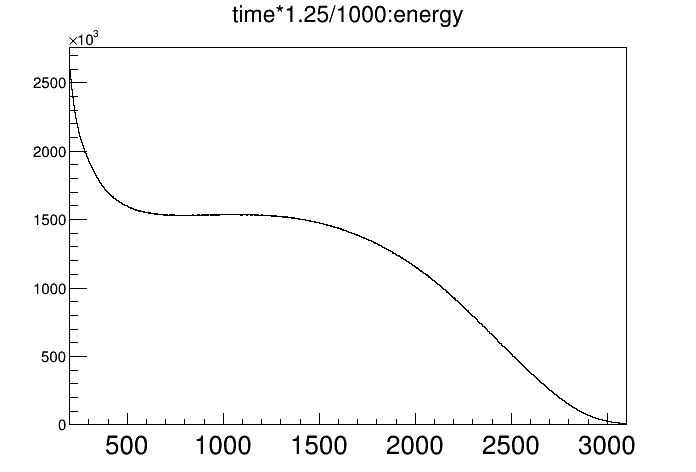

In [12]:
c2 = r.TCanvas()
e1 = 200 #200 and 3100 produced a stable result in the visualizer
e2 = 3100
t1 = 30
t2 = 600
evt.GetXaxis().SetRangeUser(e1,e2)
evt.GetYaxis().SetRangeUser(30,600)

cuti = r.TCutG("cuti")
cuti.SetPoint(0,e1,t1)
cuti.SetPoint(1,e2,t1)
cuti.SetPoint(2,e2,t2)
cuti.SetPoint(3,e1,t2)
cuti.SetPoint(4,e1,t1)

h = evt.ProjectionX("h",0,-1,"[cuti]").Clone()
#h.Scale(1/(h.GetEntries()))
h.Draw()
c2.Draw()

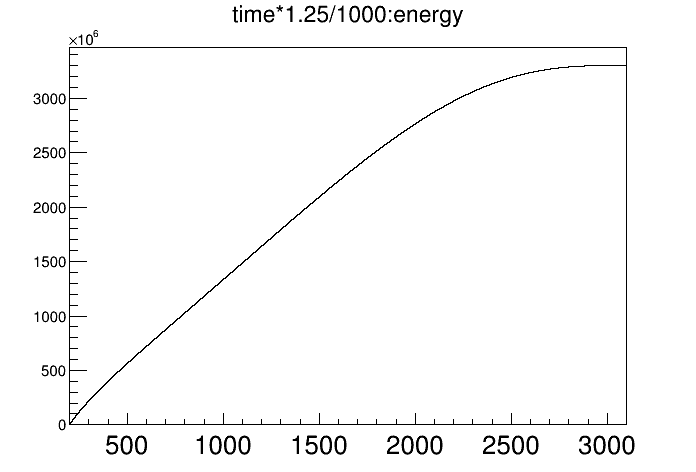

In [13]:
hcum = h.GetCumulative()
c2 = r.TCanvas()
hcum.Draw()
c2.Draw()

In [14]:
hscaled = h.Clone("hscaled")
hscaled.Scale(1/(hscaled.GetEntries()))

In [15]:
ndivs = len(timeBinCenters)
print(ndivs)
timeSlices = []
timeSlicesCum = []
times = []
for div in range(ndivs):
    t1 = timeBinCenters[div] - timeBinWidth
    t2 = timeBinCenters[div] + timeBinWidth
    evt.GetYaxis().SetRangeUser(t1,t2)
    
    cuti = r.TCutG("cuti")
    cuti.SetPoint(0,e1,t1)
    cuti.SetPoint(1,e2,t1)
    cuti.SetPoint(2,e2,t2)
    cuti.SetPoint(3,e1,t2)
    cuti.SetPoint(4,e1,t1)

    htemp = evt.ProjectionX("htemp",0,-1,"[cuti]").Clone()
    htemp.SetTitle("EvT Projection from Time Slice "+str(t1).zfill(3)+" - "+str(t2).zfill(3))
    #htemp.Scale(1/(htemp.GetEntries()))
    
    '''
    hprint = htemp.Clone("hprint")
    hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaled.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    c.Print("./images/evt_"+str(div).zfill(5)+".png")
    '''
    
    timeSlices.append(htemp.Clone("h"+str(div+1)))
    timeSlicesCum.append(htemp.GetCumulative().Clone("hcum"+str(div+1)))
    times.append(t1)

3828


In [16]:
hscaledcum = hcum.Clone("hscaledcum")
#hscaled.Scale(1/(hscaled.GetEntries()))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>:

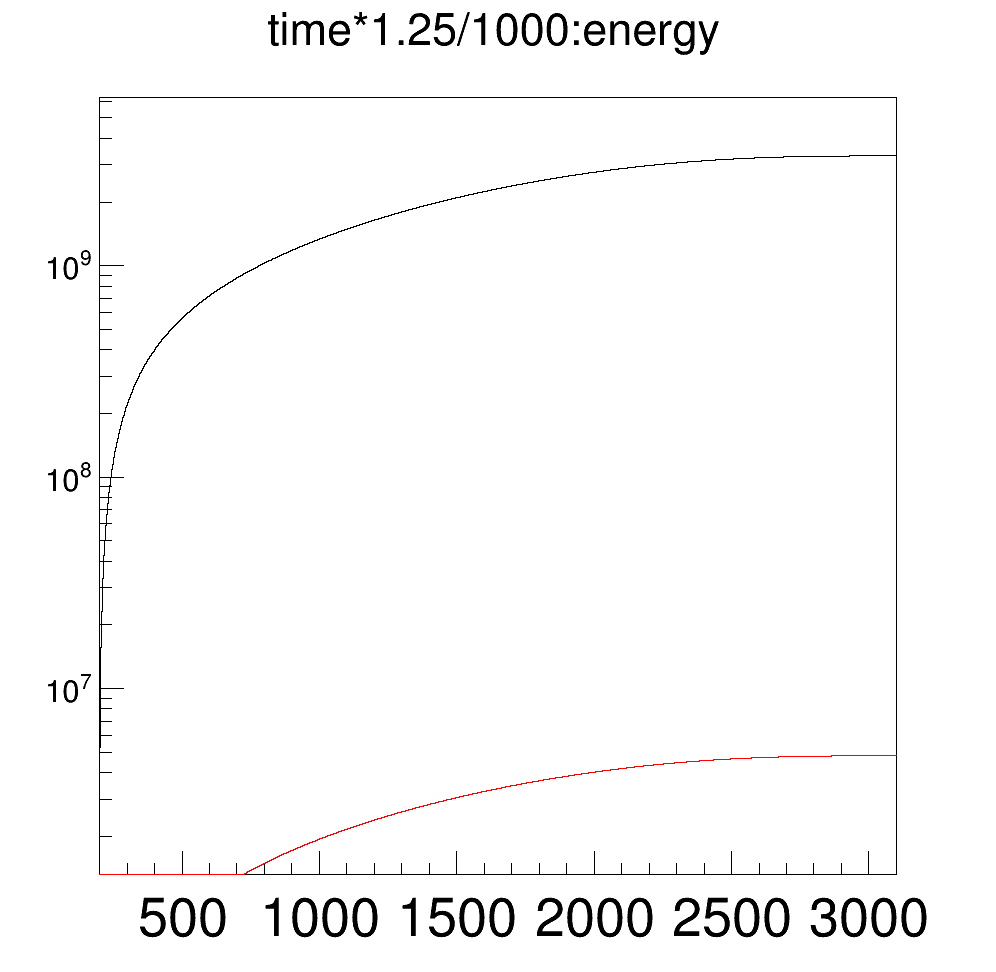

In [17]:
for div in range(500):#ndivs):
    hprint = timeSlicesCum[div].Clone("hprint")
    #hprint.Scale(1/(hprint.GetEntries()))
    c = r.TCanvas("c","c",1000,1000)
    hscaledcum.Draw("HIST")
    hprint.SetLineColor(2)
    hprint.Draw("HIST SAME")
    #hscaled.GetXaxis().SetRangeUser(0.0001,0.01)
    c.SetLogy()
    c.Draw()
    #c.Print("./images/evt_cum_"+str(div).zfill(5)+".png")

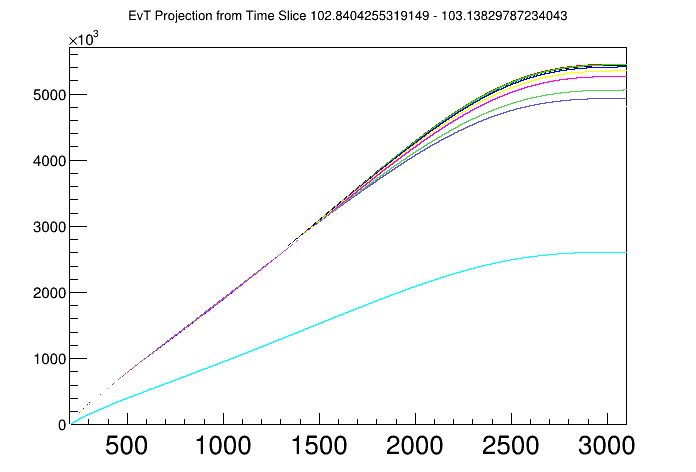

In [18]:
c = r.TCanvas()
timeSlicesCum[490].Draw("SAME")
for i in range(491,500):
    timeSlicesCum[i].SetLineColor(i-489)
    timeSlicesCum[i].Draw("HIST SAME")
c.Draw()

In [19]:
ks = []
for i, hslice in enumerate(timeSlicesCum):
    ksi = hcum.KolmogorovTest(hslice,"M")
    ks.append(ksi)

print(ks)

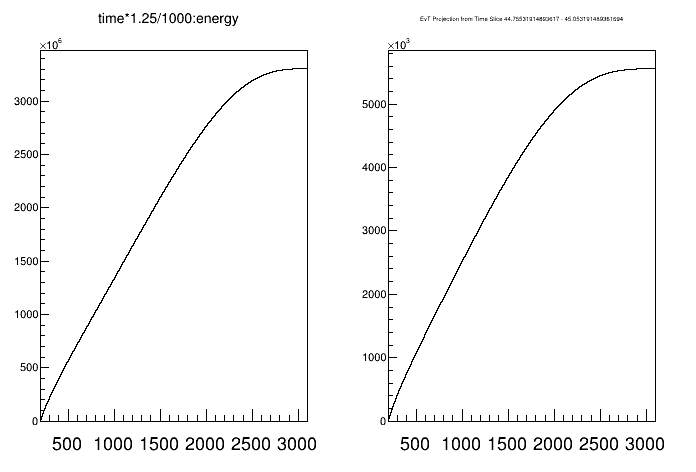

In [20]:
c = r.TCanvas()
c.Divide(2)
c.cd(1)
hcum.Draw()
c.cd(2)
timeSlicesCum[100].Draw()
c.Draw()

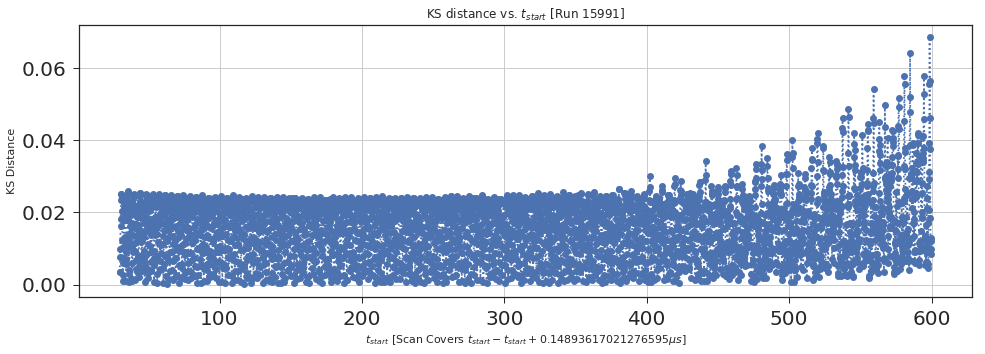

In [21]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,':o')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.grid()
plt.show()

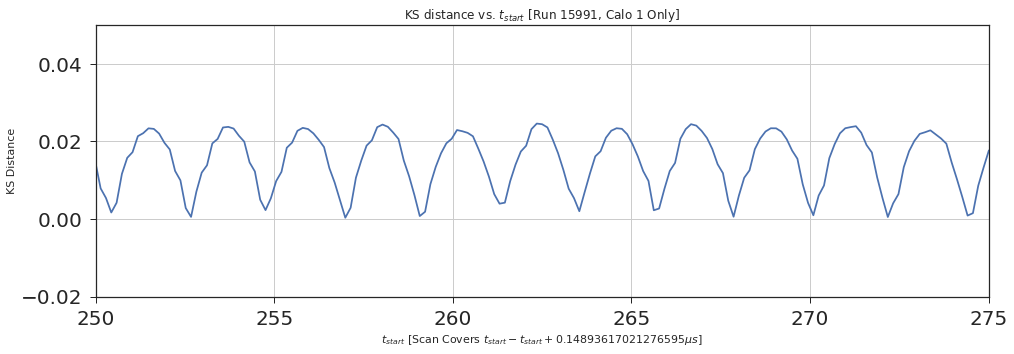

In [22]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(times,ks,'-')
plt.title(r"KS distance vs. $t_{start}$ [Run 15991, Calo 1 Only]")
plt.xlabel(r"$t_{start}$ [Scan Covers $t_{start} - t_{start} + "+str(timeBinWidth)+r" \mu s$]")
plt.ylabel("KS Distance")
plt.xlim(250,275)
plt.ylim(-0.02,0.05)
plt.grid()
plt.show()

In [23]:
hspec = r.TH1D("hspec","hspec",4700,0,700)
for i, ksi in enumerate(zip(times,ks)):
    binnum = hspec.FindBin(ksi[0])
    hspec.SetBinContent(binnum,ksi[1])

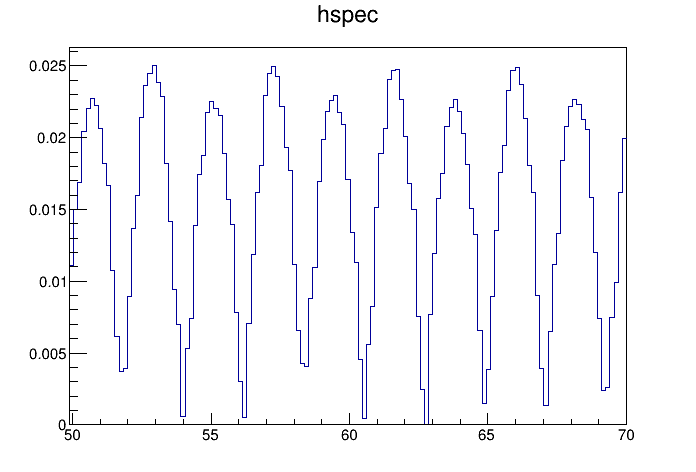

In [24]:
c = r.TCanvas()
hspec.Draw()
hspec.GetXaxis().SetRangeUser(50,70)
c.Draw()

In [25]:
hspec_orig = hspec.Clone() #keep this one unchanged so we can keep getting fit histograms from it

In [26]:
hspec2 = hspec.Clone()
hspec3 = hspec.Clone()
hspec4 = hspec.Clone()

In [27]:
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def peak_fit_sine(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3]

def peak_fit_sine_2(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return p[0]*r.TMath.Abs(r.TMath.Sin(omega*x[0] + p[2])) + p[3] +p[4]*r.TMath.Sin(omega*x[0] + p[2])

func1 = r.TF1("simplesine", peak_fit_sine, 50,350,4)
func1.SetParNames('A','R','#phi','+ C')
func1.SetParameters(0.03,0,0,0.002)
func1.SetParLimits(0,0.02,100)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("complexsine", peak_fit_sine_2, 50,350,5)
func2.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', '#phi_{2}')
func2.SetParameters(0.03,0,0,0.002,0.002,0)
func2.SetParLimits(0,0.02,100)
func2.SetLineColor(3)
func2.SetNpx(1000)

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


 FCN=0.026164 FROM MINOS     STATUS=PROBLEMS      292 CALLS        3349 TOTAL
                     EDM=7.22338e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            2.45547e-02   2.28555e-02  -1.42361e-05   4.68869e-02
   2  R           -4.16212e+02   4.11093e+04   1.77548e-05   1.28653e-05
   3  #phi         3.95915e+00   3.62318e+00  -2.96599e-04   2.35596e-03
   4  + C         -6.88862e-04   6.94081e-03   6.94081e-03  -3.06575e-02


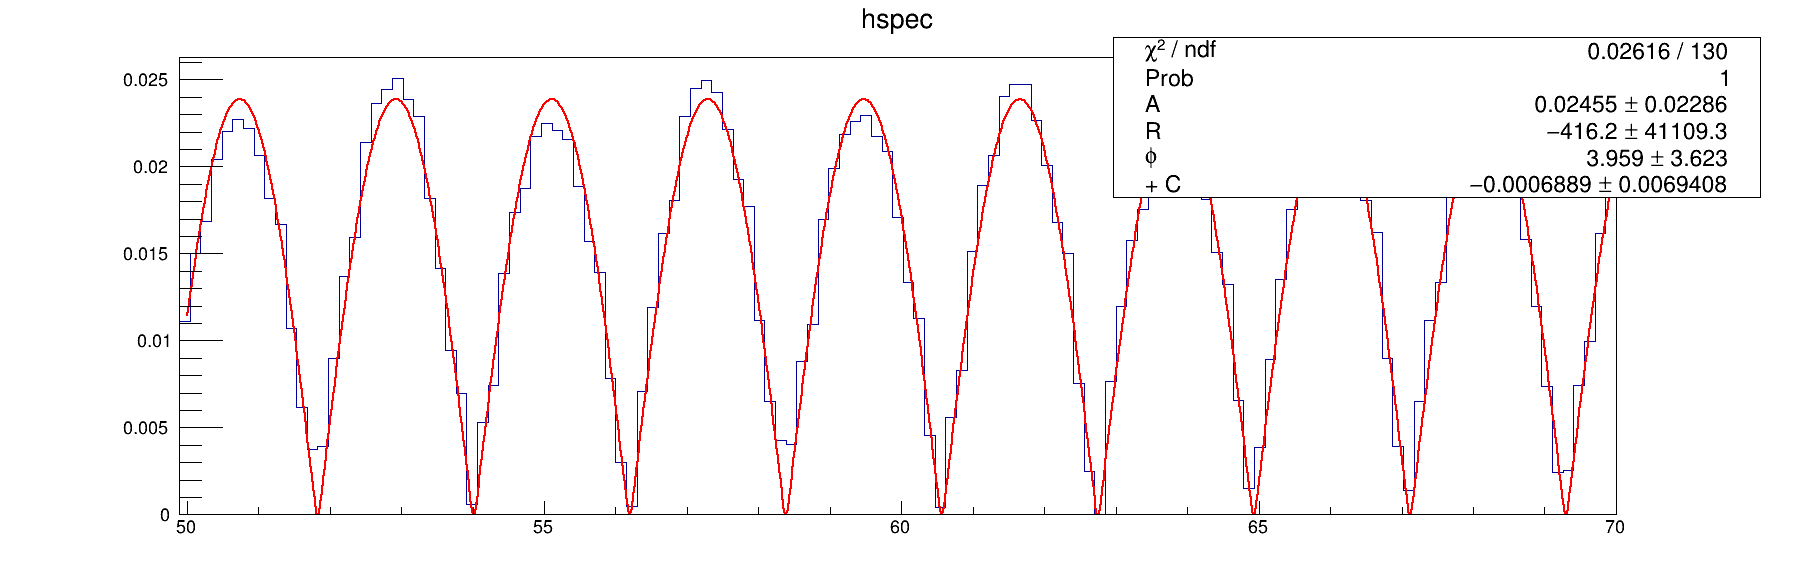

In [28]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()

hspec2.GetXaxis().SetRangeUser(50,550)
hspec.Fit("simplesine","REMB")
hspec2.GetXaxis().SetRangeUser(50,70)

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


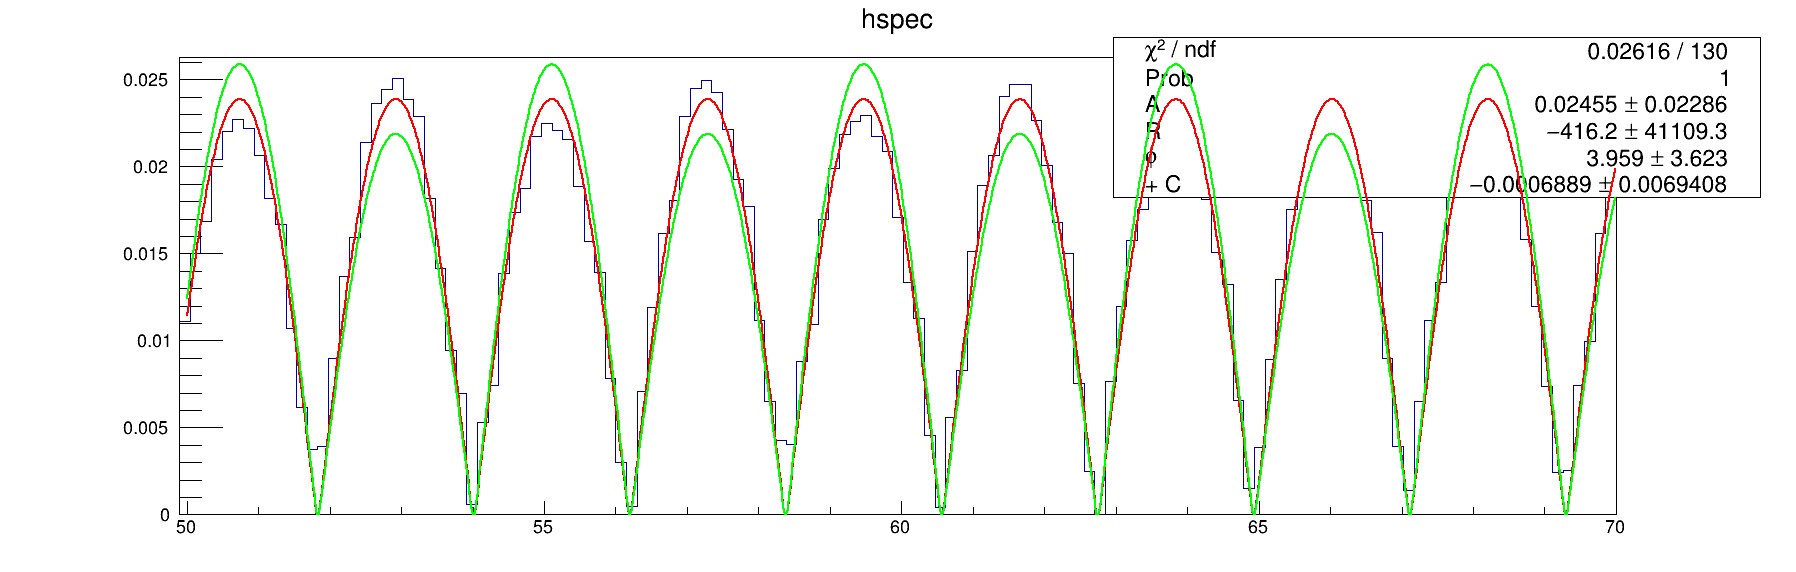

In [29]:
c = r.TCanvas("c","c",1800,600)
hspec.Draw()
for i in range(4):
    func2.SetParameter(i, func1.GetParameter(i))    
func1.Draw("SAME")
func2.Draw("SAME")
c.Draw()

In [30]:
func2.FixParameter(2, func1.GetParameter(2))

 FCN=0.0229876 FROM MINOS     STATUS=SUCCESSFUL     48 CALLS        1008 TOTAL
                     EDM=6.83631e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.46416e-02   2.21501e-02   7.65515e-05  -4.87930e-03
   2  R           -4.10081e+02   2.80574e+03  -4.09037e+00   3.64476e-07
   3  #phi_{1}     3.95915e+00     fixed    
   4  + C         -6.77655e-04   6.69758e-03   1.48981e-05   1.27141e-01
   5  A_{2}       -9.40750e-04   1.66763e-02   1.66763e-02  -1.67830e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


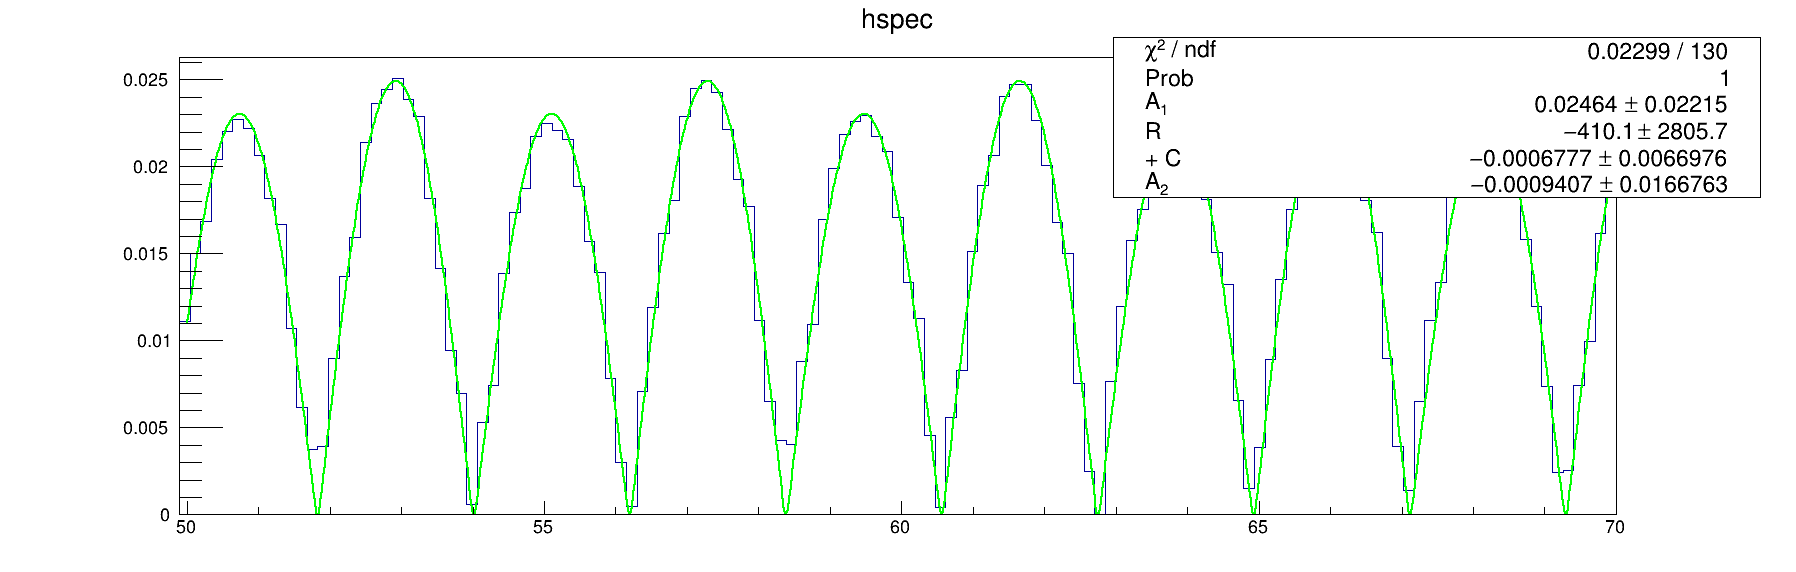

In [31]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.Fit("complexsine","REMB")
#func2.Draw("SAME")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


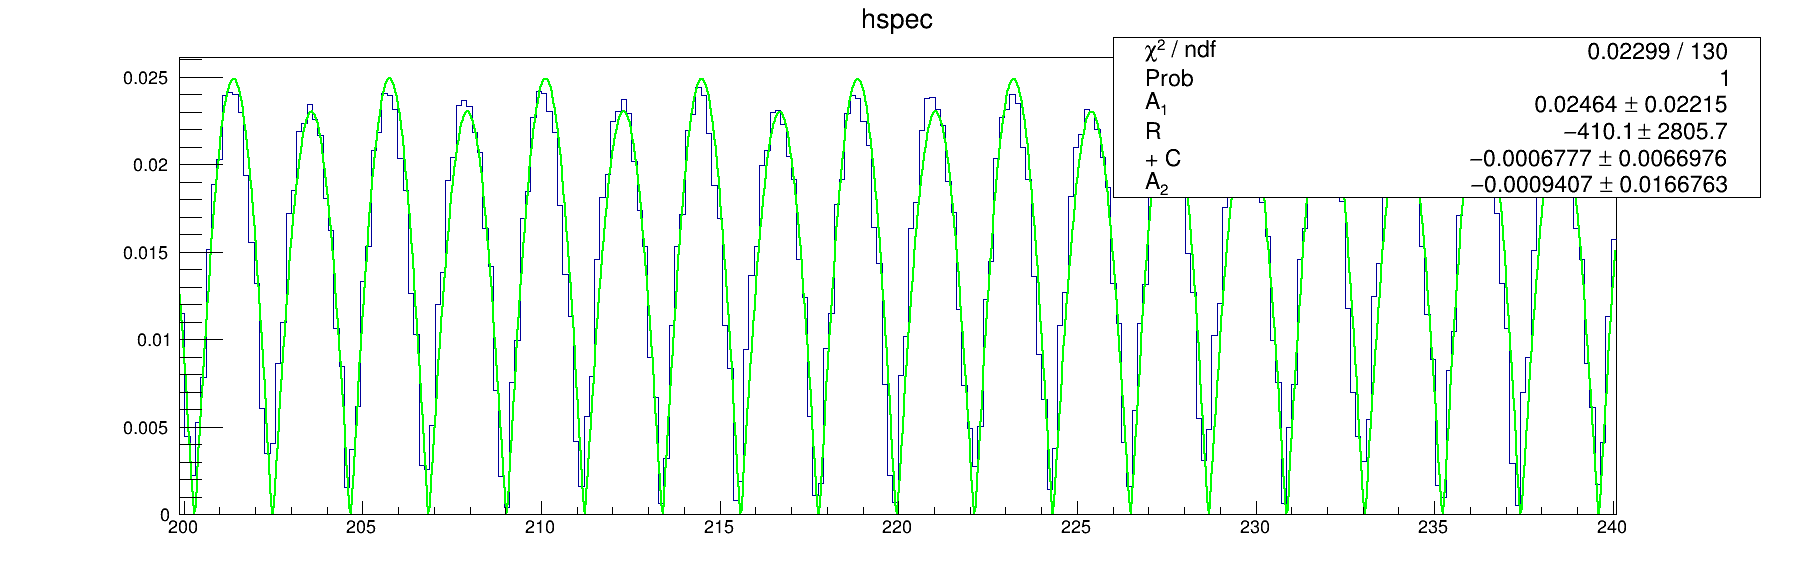

In [32]:
c = r.TCanvas("c","c",1800,600)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(200,240)
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


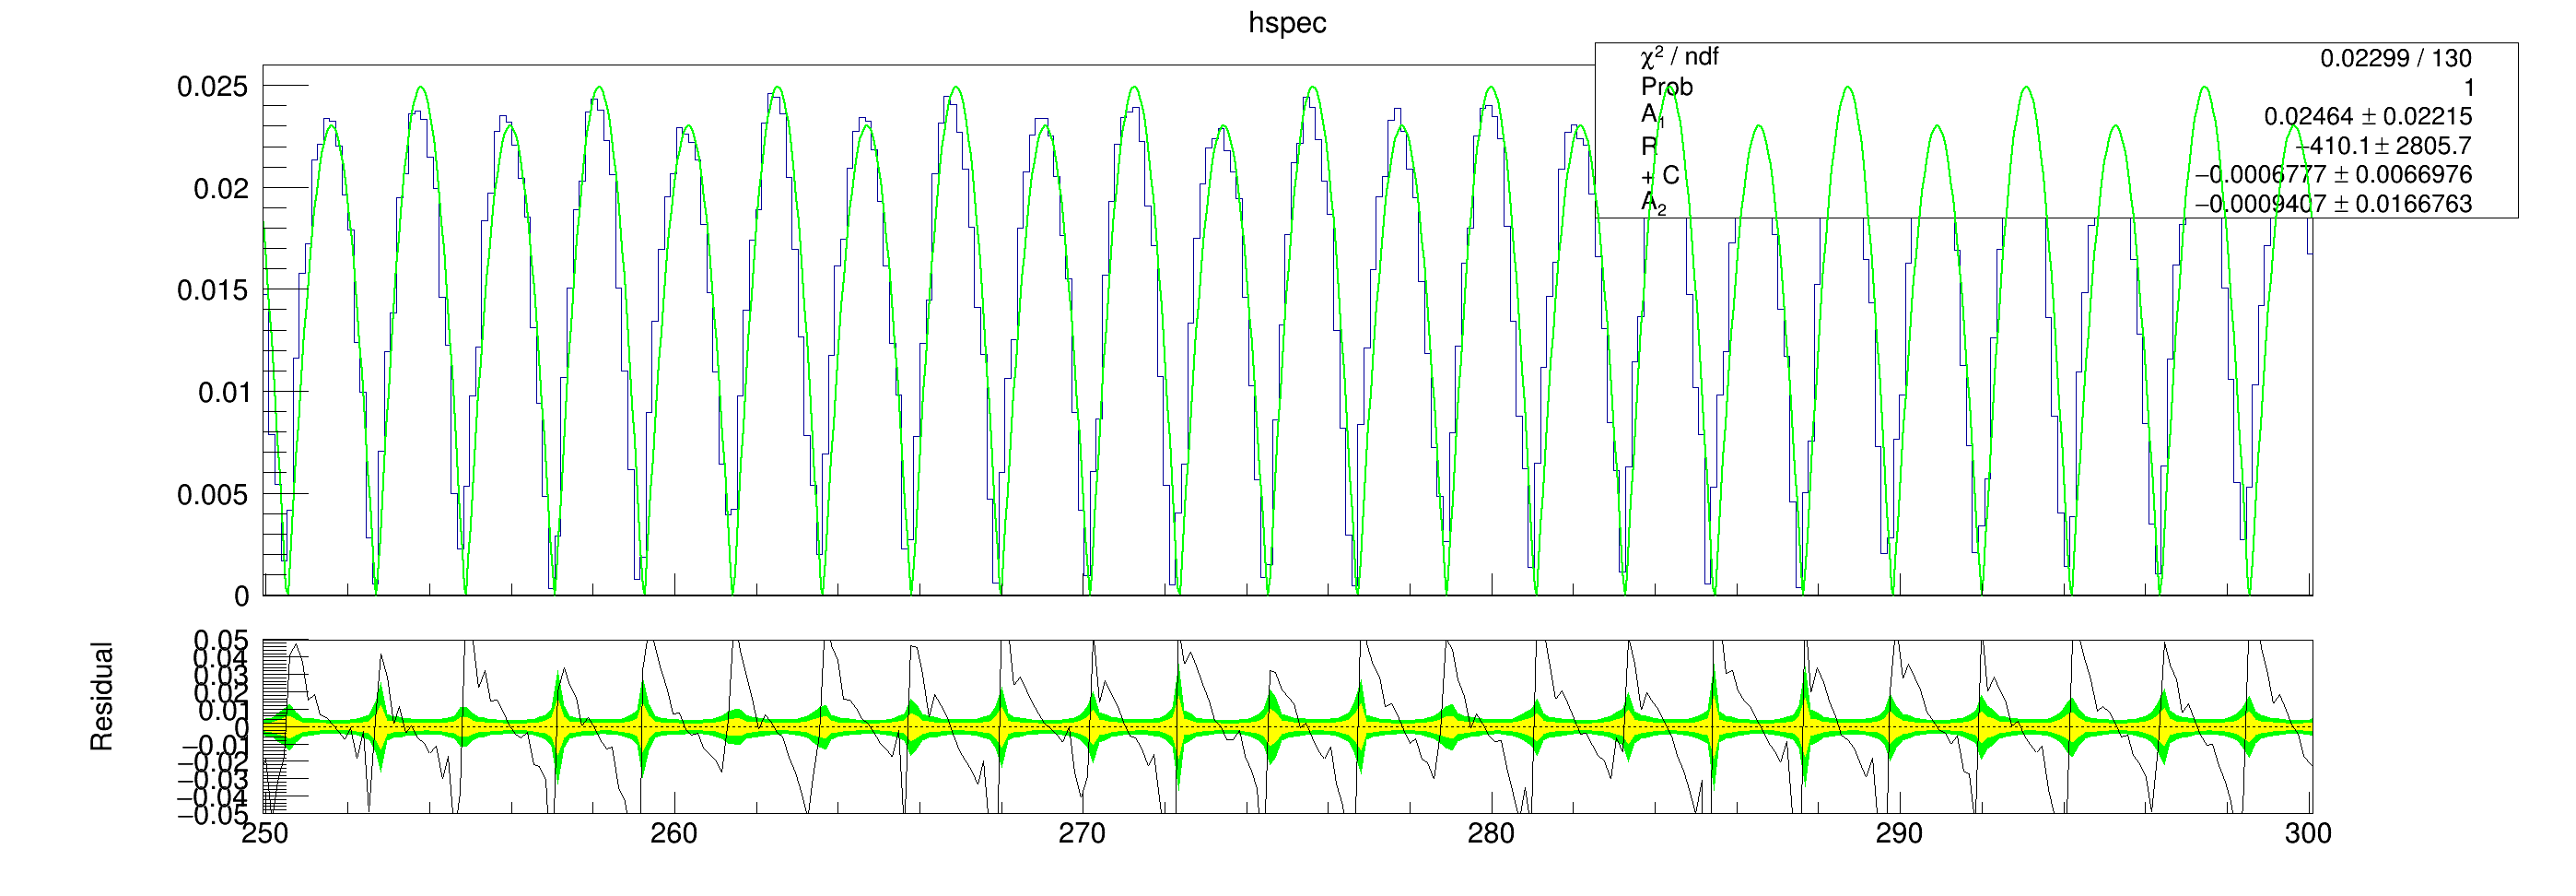

In [34]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec2.Draw()
hspec2.GetXaxis().SetRangeUser(250,300)

c3.Draw()

try:
    rp1.Delete()
except:
    print("hi")

rp1 = r.TRatioPlot(hspec2)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

div = 3
for i in range(50,600,div):
    hspec2.GetXaxis().SetRangeUser(i,i+20)
    c3.Update()
    c3.Print("./images/rp1_"+str(i).zfill(4)+".png")
c3.Draw()

--- 

### Lets bring in the moonshot residuals from the Toy KS fitter

In [138]:
def peak_fit_sine_3(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    #return ( p[0] + p[4]*r.TMath.Sin(p[1]*x[0] + p[2]) )*r.TMath.Abs(r.TMath.Sin(p[1]*x[0] + p[2])) + p[3]
    return ( p[0] + p[4]*r.TMath.Sin(omega*x[0] + p[2]) )*(r.TMath.Sin(omega*x[0] + p[2]))**2 + p[3]

func3 = r.TF1("moonshot", peak_fit_sine_3, 50,250,5)
func3.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', '#phi_{2}')
func3.SetParameters(0.03,1,1,1,1,1)
#func3.SetParLimits(0,0.02,100)
func3.FixParameter(3,0)
func3.SetLineColor(6)
func3.SetNpx(1000)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


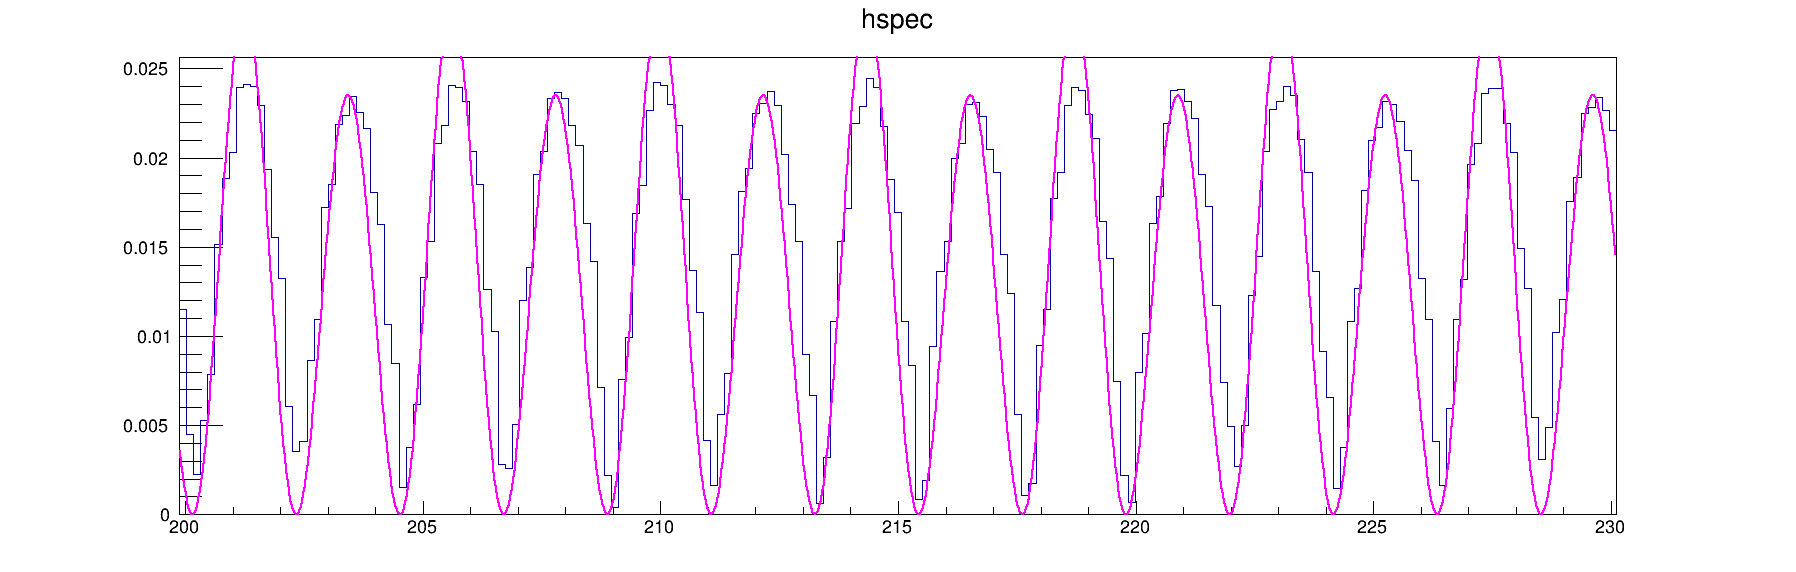

In [139]:
c = r.TCanvas("c","c",1800,600)
hspec3.Draw("")
func3.SetParameters(0.026,1.45,0.91,0,0.0025,0)
func3.Draw("SAME")
hspec3.GetXaxis().SetRangeUser(200,230)

c.Draw()

 FCN=1.58839 FROM MINOS     STATUS=SUCCESSFUL     30 CALLS        1692 TOTAL
                     EDM=5.83605e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.79528e-02   6.44159e-03  -1.79743e-06  -5.08131e-03
   2  R           -1.15117e+02   2.55480e+03   2.90804e+00  -6.05271e-08
   3  #phi_{1}     8.28485e-01   5.84546e-01  -6.46835e-04  -2.56374e-04
   4  + C          0.00000e+00     fixed    
   5  A_{2}        3.44682e-04   7.20430e-03   7.20430e-03  -4.99872e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


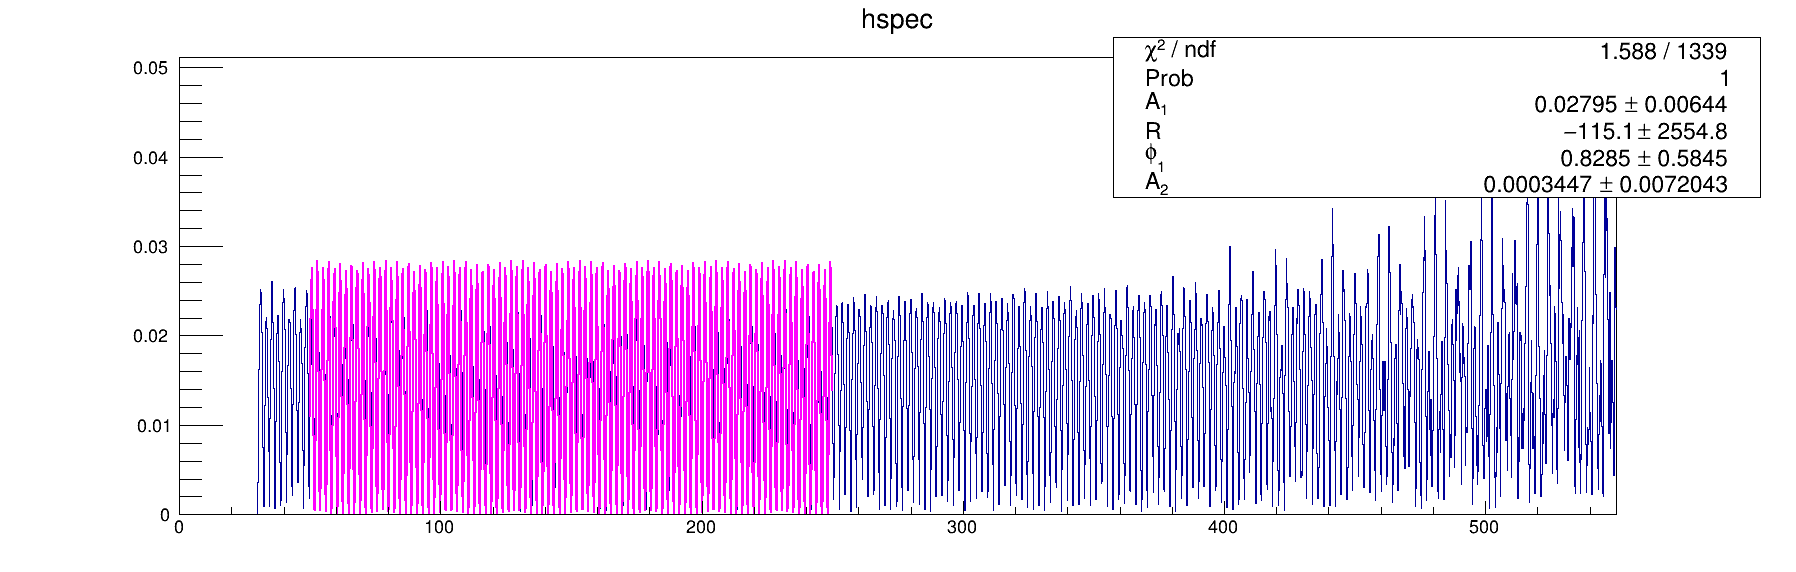

In [140]:
c = r.TCanvas("c","c",1800,600)

hspec3.GetXaxis().SetRangeUser(0,550)
hspec3.Draw()
hspec3.Fit("moonshot","REMB")

c.Draw()

In [141]:
hspec3_resid = hspec3.Clone()
hspec3_resid.Reset()

for i in range(hspec3_resid.GetNbinsX()):
    hspec3_resid.SetBinContent(i, hspec3.GetBinContent(i) - func3.Eval(hspec3.GetXaxis().GetBinCenter(i)))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


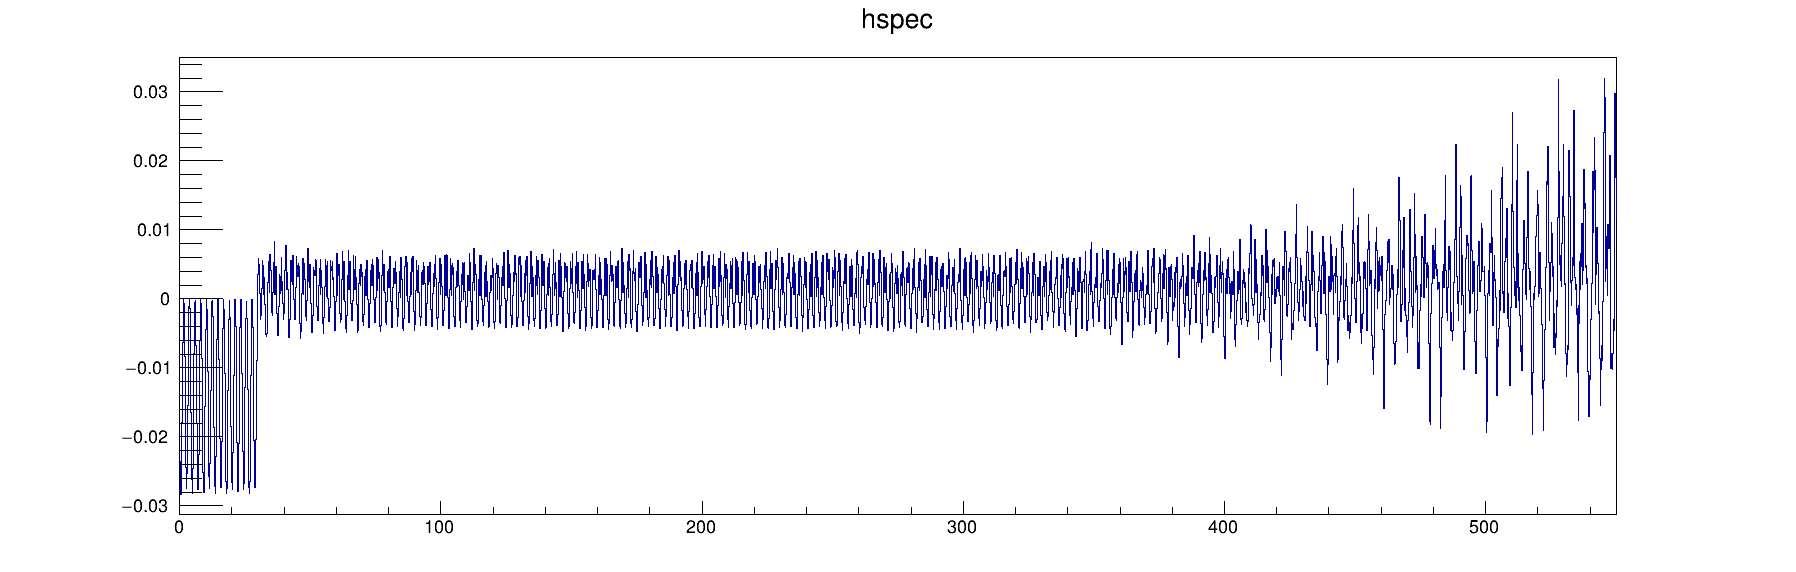

In [142]:
c = r.TCanvas("c","c",1800,600)
hspec3_resid.Draw()
c.Draw()

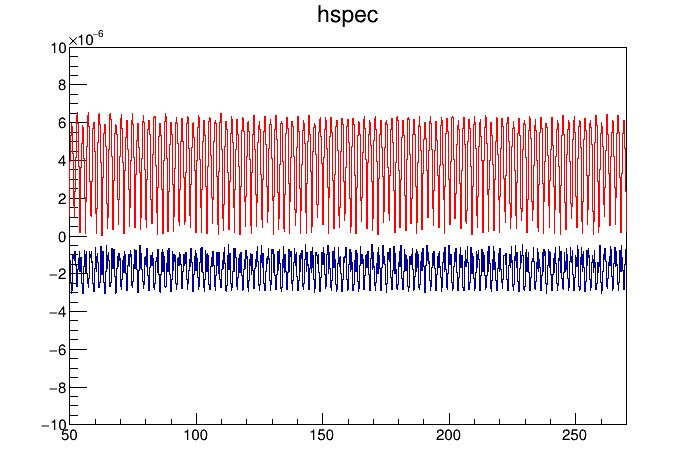

In [143]:
hspec3_resid_scaled = hspec3_resid.Clone()
hspec3_scaled = hspec3.Clone()

hspec3_resid_scaled.Scale(1/(hspec3_resid_scaled.GetEntries()))
hspec3_scaled.Scale(1/(hspec3_scaled.GetEntries()))

for i in range(hspec3_resid_scaled.GetNbinsX()):
    content = hspec3_resid_scaled.GetBinContent(i)
    hspec3_resid_scaled.SetBinContent(i, content - 2*(10**-6))

hspec3_scaled.SetLineColor(2)



c = r.TCanvas()
hspec3_resid_scaled.Draw("HIST")
hspec3_resid_scaled.GetXaxis().SetRangeUser(50,270)
hspec3_resid_scaled.GetYaxis().SetRangeUser(-0.00001,0.00001)
hspec3_scaled.Draw("HIST SAME")
c.Draw()

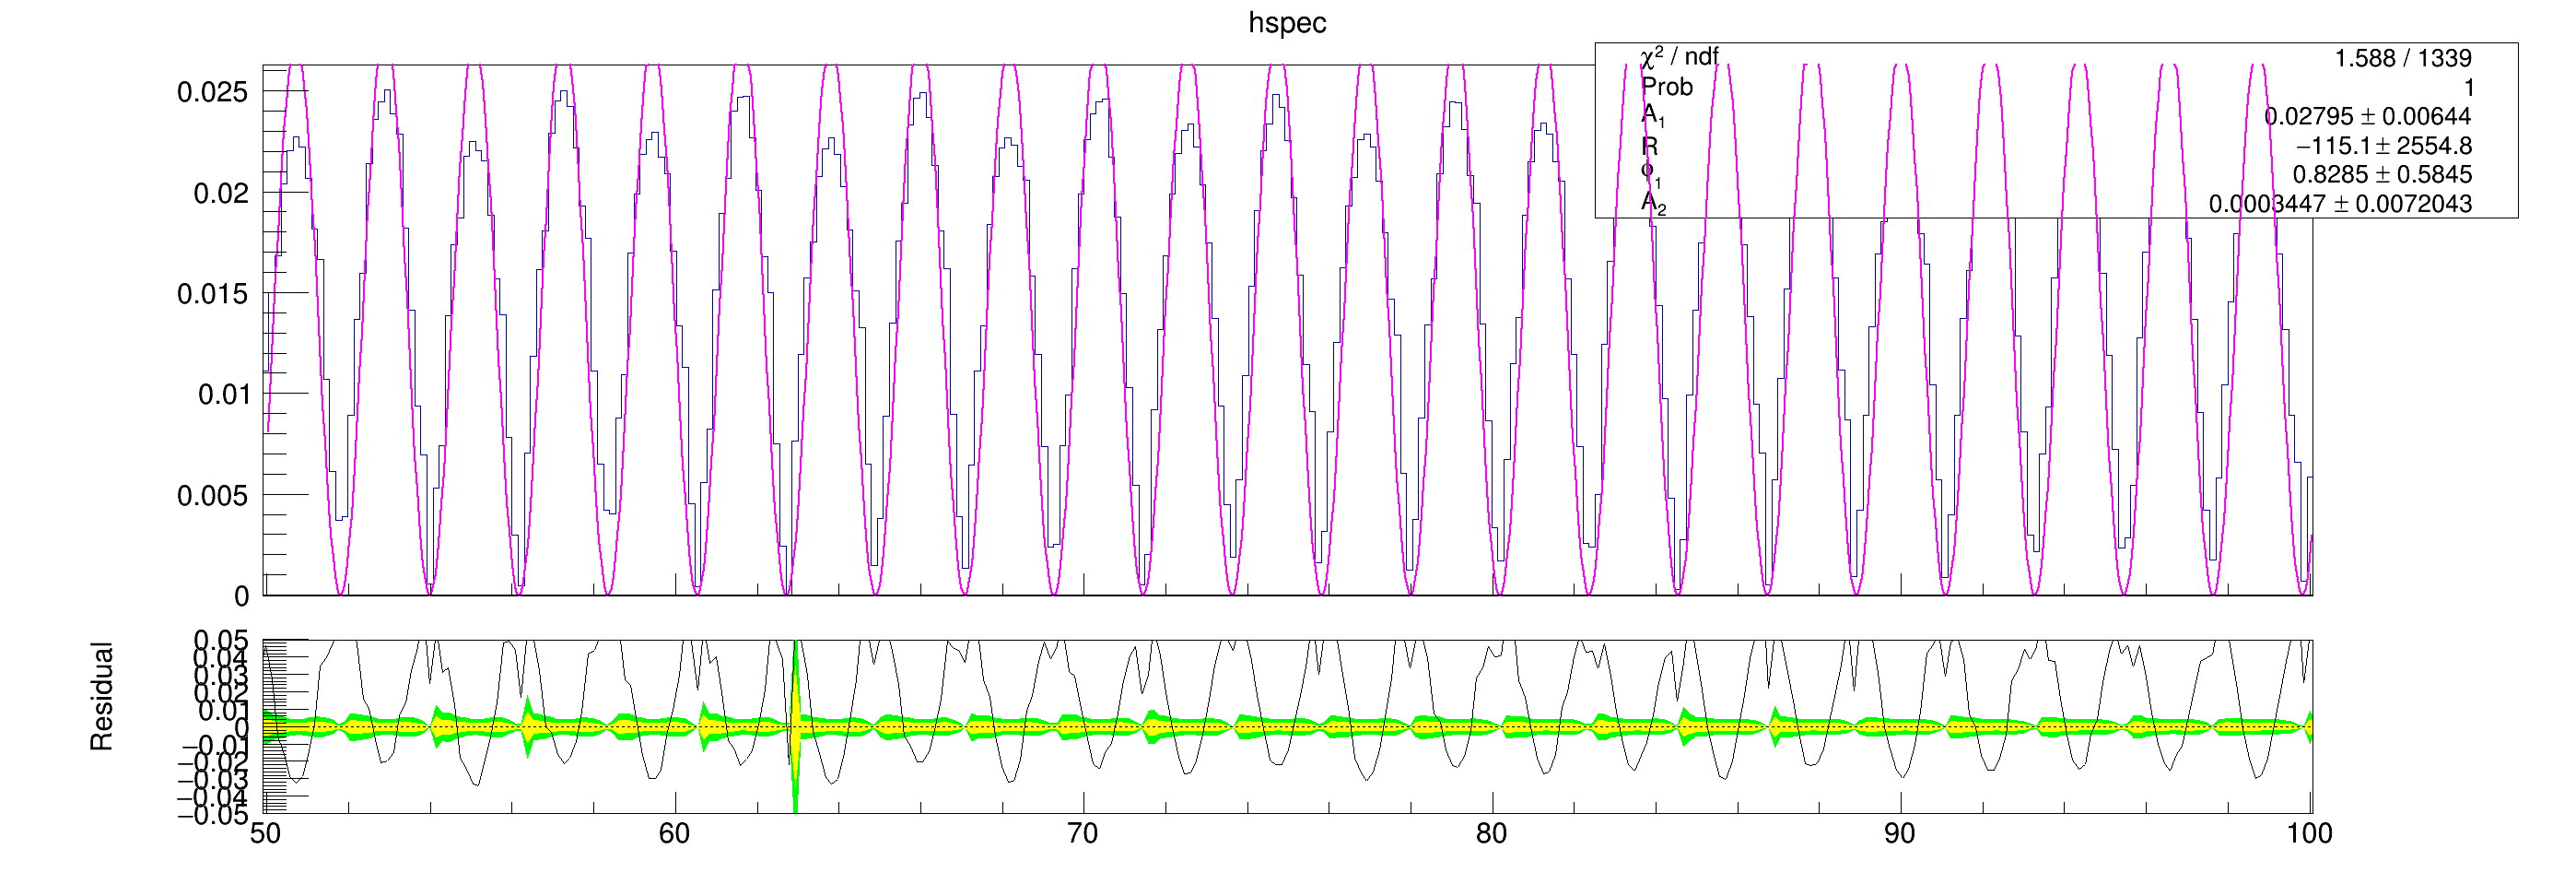

In [144]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c3 = r.TCanvas("c","c",2800,1000)
hspec3.Draw()
hspec3.GetXaxis().SetRangeUser(50,100)

c3.Draw()

try:
    rp1.Delete()
except:
    print("hi")

rp1 = r.TRatioPlot(hspec3)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-0.05,0.05)


c3.Update()
c3.Draw()

---

### Can we fit these residuals with a simple sine wave?

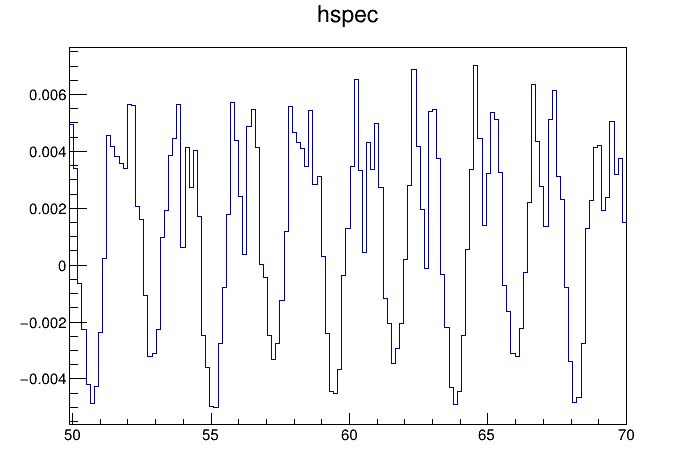

In [145]:
c = r.TCanvas()
hspec3_resid.Draw()
hspec3_resid.GetXaxis().SetRangeUser(50,70)
c.Draw()

In [146]:
def resid_fit_sine(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)

    return p[0]*(r.TMath.Sin(omega*x[0] + p[2]))**2 + p[3]

func5 = r.TF1("residfit", resid_fit_sine, 50,150,4)
func5.SetParNames('A','R','#phi','+ C')
func5.SetParameters(0.01,1,1,1)
func5.SetLineColor(7)
func5.SetNpx(1000)

 FCN=0.267291 FROM MINOS     STATUS=SUCCESSFUL    223 CALLS        3198 TOTAL
                     EDM=6.89901e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            3.72930e-03   9.85521e-03   9.88988e-06  -3.64996e-02
   2  R            1.00062e+03   1.26420e+05   4.03627e+02  -9.56323e-08
   3  #phi        -8.14193e-01   1.06796e+01  -3.20582e-02  -1.22090e-03
   4  + C         -1.35958e-03   5.32478e-03   5.32478e-03  -6.43483e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


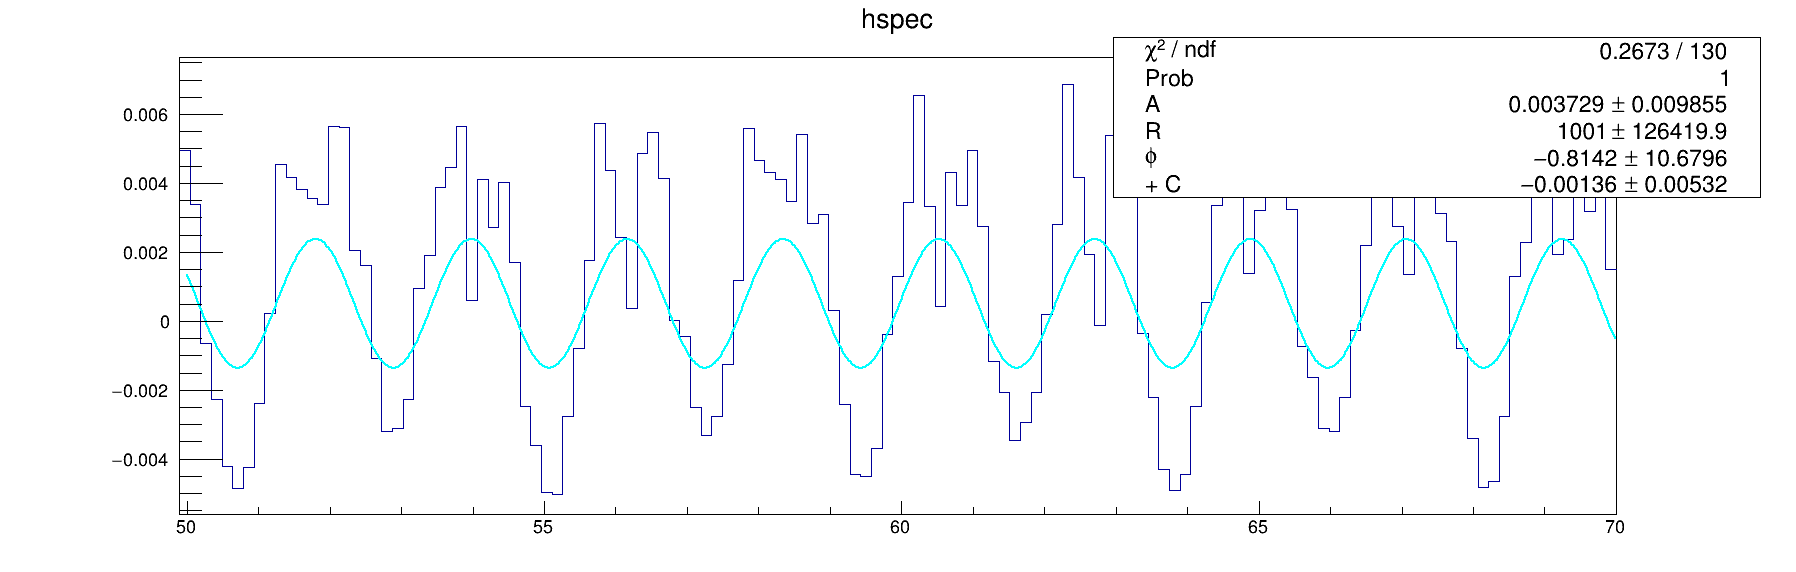

In [147]:
c = r.TCanvas("c","c",1800,600)
hspec3_resid.Draw()
hspec3_resid.GetXaxis().SetRangeUser(50,70)
func5.SetParameters(0.01,0,-0.5,-0.0035)

hspec3_resid.Fit("residfit","REMB")
#func5.Draw("SAME")
c.Draw()

 FCN=0.267291 FROM MINOS     STATUS=SUCCESSFUL    224 CALLS        3307 TOTAL
                     EDM=4.78791e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            3.72780e-03   9.85250e-03   4.09388e-06   3.40207e-02
   2  R            1.00061e+03   1.30417e+05  -1.03796e+02  -1.61303e-08
   3  #phi        -8.14194e-01   1.10170e+01   9.26160e-03  -1.95210e-04
   4  + C         -1.35970e-03   5.32486e-03   5.32486e-03   5.48790e-02
 FCN=0.267291 FROM MINOS     STATUS=SUCCESSFUL    234 CALLS        3551 TOTAL
                     EDM=3.80193e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            3.72767e-03   9.85202e-03   8.58228e-06  -4.01243e-02
   2  R            9.99951e+02 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


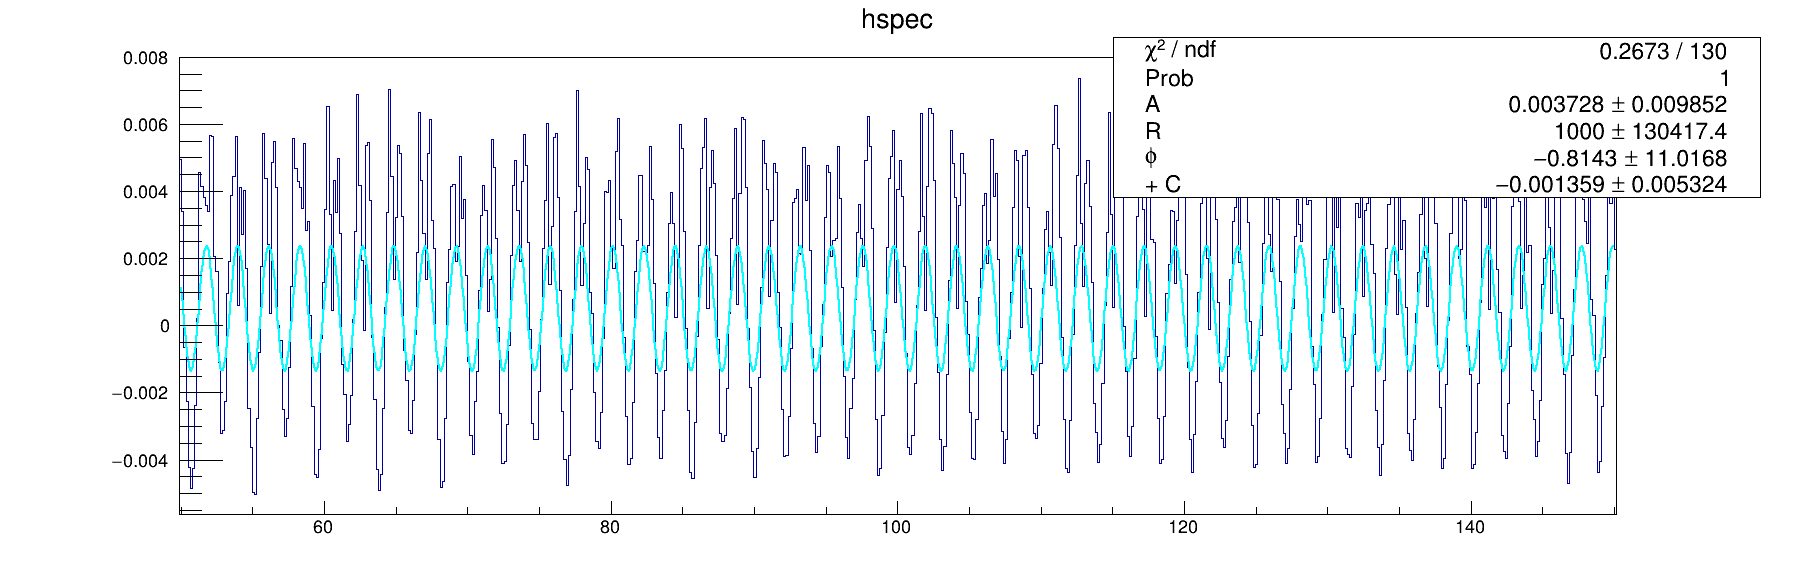

In [148]:
c = r.TCanvas("c","c",1800,600)
hspec3_resid.Draw()
for i in range(2):
    hspec3_resid.Fit("residfit","REMB")
hspec3_resid.GetXaxis().SetRangeUser(50,150)
c.Draw()

No, it doesnt want to fit at all... Which isn't negessarily a bad thing, that dip in the middle of the peak would be a serious pain in the ass 

---

### Looks like there is an oscillation which is 180 degrees out of phase with the initial version. Lets add this into moonshot

In [149]:
def peak_fit_sine_4(x, p):
    R = p[1]
    omega = getBlinded.paramToFreq(R)
    return ( p[0] + p[4]*r.TMath.Sin(omega*x[0] + p[2]) )*(r.TMath.Sin(omega*x[0] + p[2]))**2 + p[3] + p[5]*r.TMath.Sin(omega*x[0] + p[3] + r.TMath.Pi())

func4 = r.TF1("moonshot2", peak_fit_sine_4, 50,250,6)
func4.SetParNames('A_{1}','R','#phi_{1}','+ C', 'A_{2}', 'A_{3}','#phi_{3}')
func4.SetParameters(0.026,1.45,0.91,0,0.0025,0.002)
#func4.FixParameter(3,0)
#func4.SetParLimits(6,0,6.3)
func4.SetParLimits(2,0,6.3)
func4.SetLineColor(7)
func4.SetNpx(1000)

 FCN=1.01074 FROM MINOS     STATUS=SUCCESSFUL    204 CALLS         973 TOTAL
                     EDM=5.78348e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A_{1}        2.52165e-02   7.37769e-03   1.79489e-06   6.94652e-03
   2  R           -2.74572e+01   2.06071e+03   8.90322e+00   6.56840e-08
   3  #phi_{1}     8.03095e-01   4.54443e-01  -9.23390e-04   3.19057e-04
   4  + C          1.80129e-03   2.36964e-03  -2.78300e-06   3.53253e-02
   5  A_{2}        6.03130e-04   7.70183e-03  -2.84076e-05  -7.25505e-03
   6  A_{3}        3.25375e-04   3.11013e-03   3.11013e-03   3.31090e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


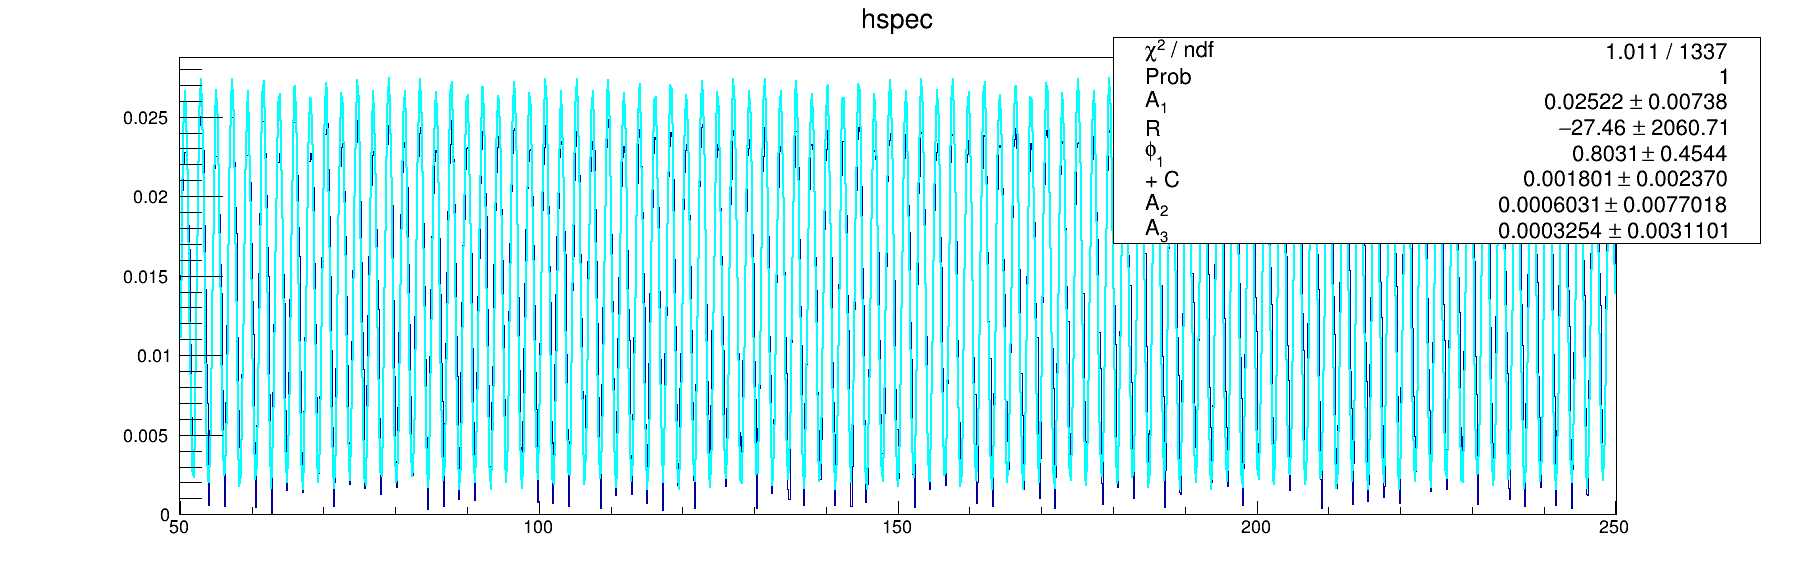

In [150]:
c = r.TCanvas("c","c",1800,600)
hspec4.GetXaxis().SetRangeUser(50,250)
hspec4.Draw("")
hspec4.Fit("moonshot2","REMB")

c.Draw()

In [151]:
hspec4_resid = hspec4.Clone()
hspec4_resid.Reset()

for i in range(hspec4_resid.GetNbinsX()):
    hspec4_resid.SetBinContent(i, hspec4.GetBinContent(i) - func4.Eval(hspec4.GetXaxis().GetBinCenter(i)))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


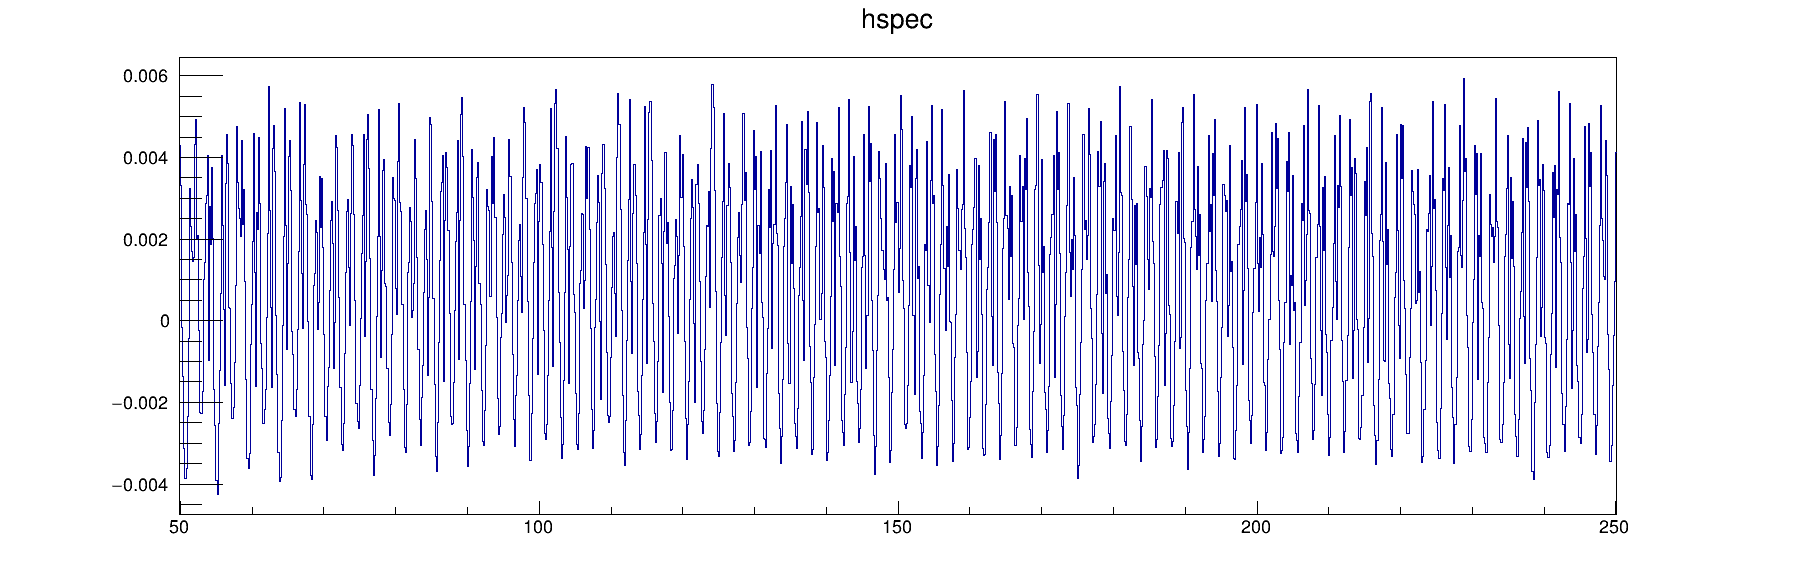

In [152]:
c = r.TCanvas("c","c",1800,600)
hspec4_resid.Draw()
c.Draw()

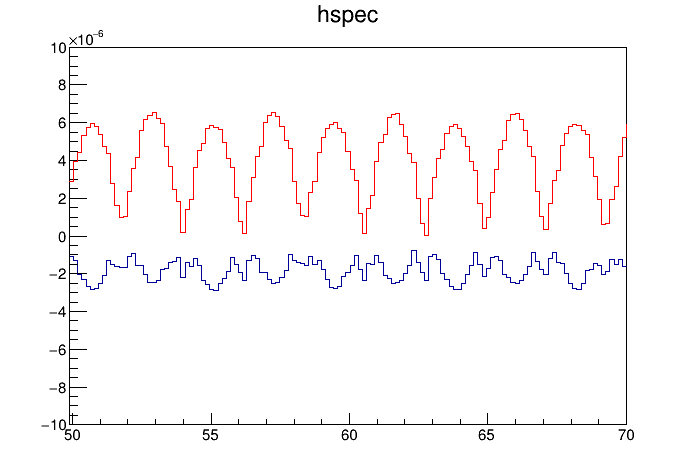

In [153]:
hspec4_resid_scaled = hspec4_resid.Clone()
hspec4_scaled = hspec4.Clone()

hspec4_resid_scaled.Scale(1/(hspec4_resid_scaled.GetEntries()))
hspec4_scaled.Scale(1/(hspec4_scaled.GetEntries()))

for i in range(hspec4_resid_scaled.GetNbinsX()):
    content = hspec4_resid_scaled.GetBinContent(i)
    hspec4_resid_scaled.SetBinContent(i, content - 2*(10**-6))

hspec4_scaled.SetLineColor(2)



c = r.TCanvas()
hspec4_resid_scaled.Draw("HIST")
hspec4_resid_scaled.GetXaxis().SetRangeUser(50,70)
hspec4_resid_scaled.GetYaxis().SetRangeUser(-0.00001,0.00001)
hspec4_scaled.Draw("HIST SAME")
c.Draw()

---
### Fourier transform of the initial function.

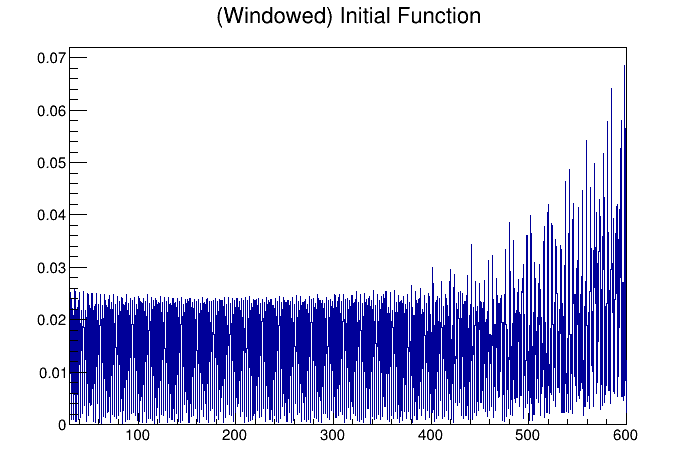

In [154]:
c3 = r.TCanvas()

centers = [x + 700./4700/2 for x in times] #times[0:int(len(times)/2)] ]
bins = ks

htest = r.TH1D("htest","htest",len(centers),centers[0],centers[len(centers)-1])
for i,ding in enumerate(bins):
    htest.SetBinContent(i, ding)
    
residuals5param = htest
nBins = residuals5param.GetSize() - 2 #total number of bins excluding over/underflow

#apply a windows function to try to get rid of the imaginary peaks
welchVec = []
for i in range(nBins):
    unwindowed = residuals5param.GetBinContent(i)
    welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
    welchVec.append(welch)
    residuals5param.SetBinContent(i, unwindowed *  welch)
    
residuals5param.Draw()
residuals5param.GetXaxis().SetRangeUser(30,700)
residuals5param.SetTitle("(Windowed) Initial Function")
c3.Draw() 

3828 569.9787234042551 29.861721581182323 599.8404449854374
0.14889726316725577 0.001754451453954982
13.432080331479343 6.716040165739671


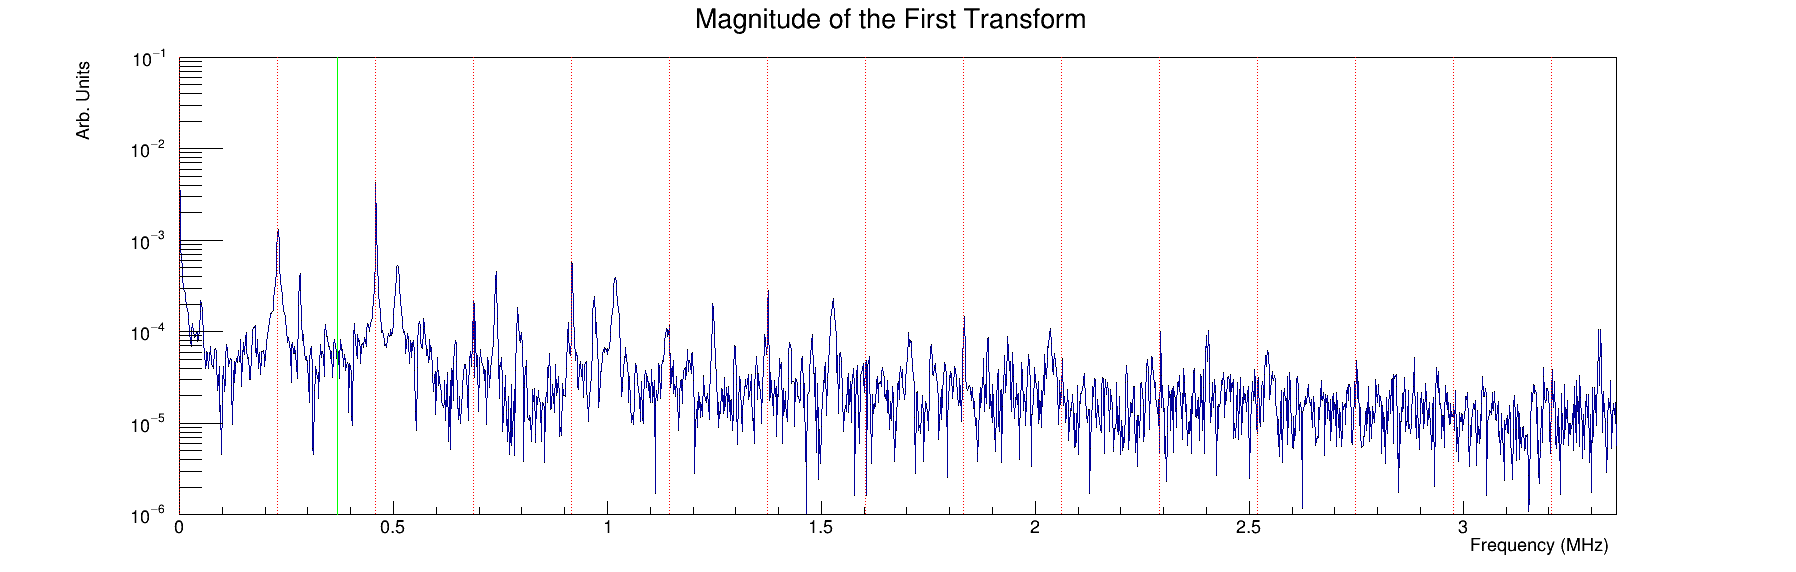

In [155]:
hxform = r.TH1D()
hxform = 0
r.TVirtualFFT.SetTransform(0)
hxform = residuals5param.FFT(hxform,"MAG P")
hxform.SetTitle("Magnitude of the First Transform")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform.GetEntries()
hxform.Scale(1/normXform)
c2 = r.TCanvas("c2","c2",1800,600)
c2.cd()
#c2.SetLogy()
hxform.GetXaxis().SetTitle("Frequency (MHz)")
hxform.GetYaxis().SetTitle("Arb. Units")
hxform.Draw("HIST P0 L")
c2.Draw()

Npart = residuals5param.GetSize() - 2
minBinCenter = residuals5param.GetXaxis().GetBinCenter(0)
maxBinCenter = residuals5param.GetXaxis().GetBinCenter(Npart)

capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10.0,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = residuals5param.GetSize() - 2
hxform.SetBins(Npart,0,limmaxMHz)
hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
#hxform.GetXaxis().SetRangeUser(0,1.4)

residuals5paramXform = hxform.Clone()

hxform.GetYaxis().SetRangeUser(0.000001,0.1)
cboline = r.TLine(0.37,0.000001,0.37,0.1)
cboline.SetLineColor(3)
cboline.Draw("SAME")
'''
oaline = r.TLine(0.23,0.000001,0.23,0.1)
oaline.SetLineColor(2)
oaline.Draw("SAME")
oaline2 = r.TLine(0.23*2,0.000001,0.23*2,0.1)
oaline2.SetLineColor(2)
oaline2.Draw("SAME")
'''
oalines = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines.append(oalinei)

c2.SetLogy()
c2.Draw()

---
### Fourier transform of the Abs(Sin(x)) fit residuals

In [156]:
hspec_resid = hspec.Clone()
hspec_resid.Reset()

residVec = []
nBins = hspec.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec.GetXaxis().GetBinCenter(i)
    if (binCenterX > 30 and binCenterX < 600):
        residVec.append( (binCenterX, hspec.GetBinContent(i) - func1.Eval(binCenterX) ) )
        hspec_resid.SetBinContent(i, hspec.GetBinContent(i) - func1.Eval(binCenterX))
    else:
        hspec_resid.SetBinContent(i, 0)

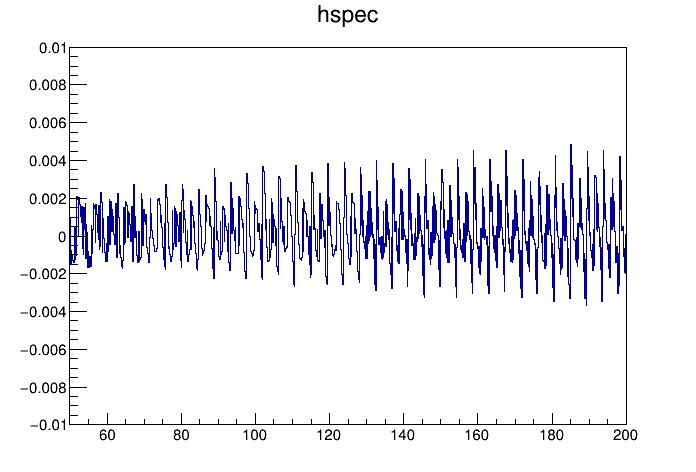

In [157]:
c = r.TCanvas()
hspec_resid.GetXaxis().SetRangeUser(50,200)
hspec_resid.GetYaxis().SetRangeUser(-0.01,0.01)
hspec_resid.Draw()
c.Draw()

4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


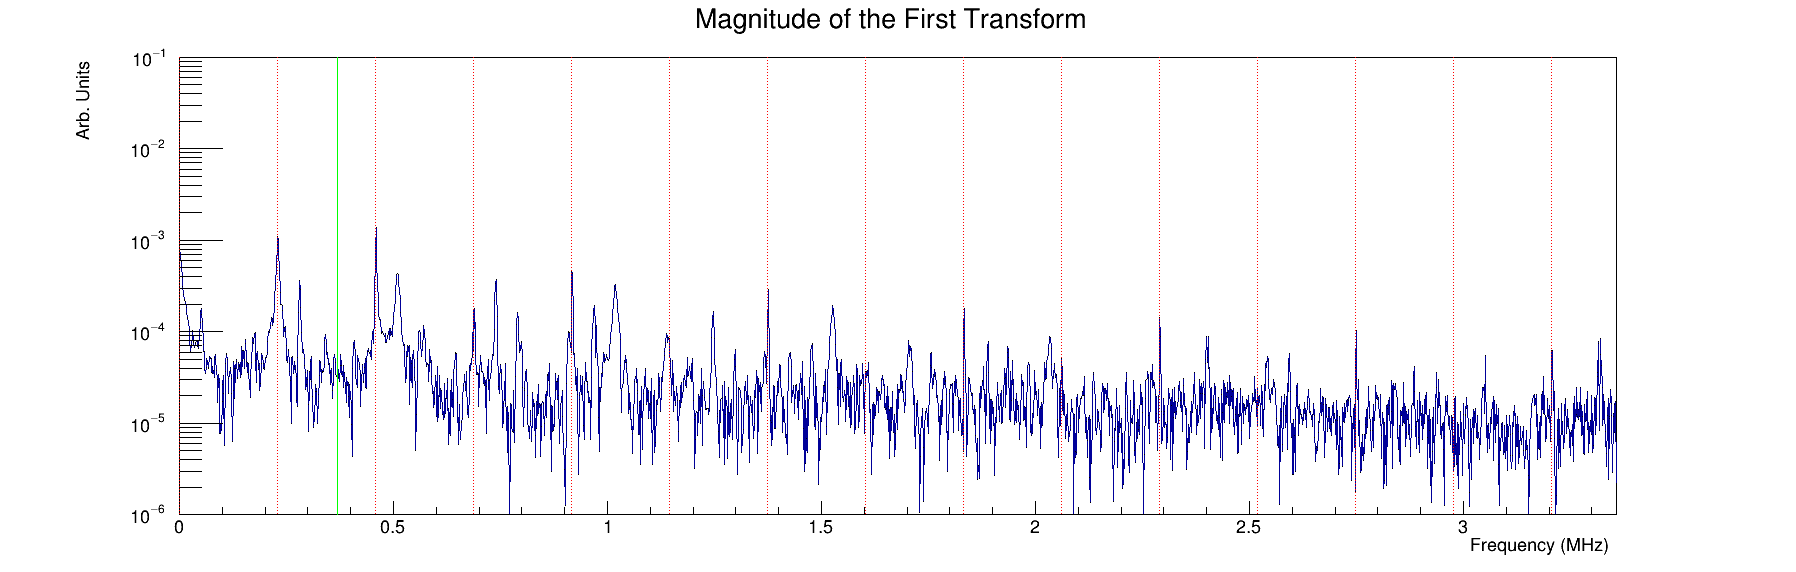

In [158]:
hxform_resid = r.TH1D()
hxform_resid = 0
r.TVirtualFFT.SetTransform(0)
hxform_resid = hspec_resid.FFT(hxform_resid,"MAG P")
hxform_resid.SetTitle("Magnitude of the First Transform")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform_resid.GetEntries()
hxform_resid.Scale(1/normXform)
c2 = r.TCanvas("c2","c2",1800,600)
c2.cd()
#c2.SetLogy()
hxform_resid.GetXaxis().SetTitle("Frequency (MHz)")
hxform_resid.GetYaxis().SetTitle("Arb. Units")
hxform_resid.Draw("HIST P0 L")
c2.Draw()

Npart = hspec.GetSize() - 2
minBinCenter = hspec.GetXaxis().GetBinCenter(0)
maxBinCenter = hspec.GetXaxis().GetBinCenter(Npart)

capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10.0,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = hxform_resid.GetSize() - 2
hxform_resid.SetBins(Npart,0,limmaxMHz)
hxform_resid.GetXaxis().SetRangeUser(0,limmaxMHz/2)

residuals5paramXform_resid = hxform_resid.Clone()

hxform_resid.GetYaxis().SetRangeUser(0.000001,0.1)
cboline = r.TLine(0.37,0.000001,0.37,0.1)
cboline.SetLineColor(3)
cboline.Draw("SAME")
oalines = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines.append(oalinei)

c2.SetLogy()
c2.Draw()

---
### Fourier transform of the Abs(Sin(x)) + Sin(x) fit residuals

In [159]:
hspec_resid_2 = hspec2.Clone()
hspec_resid_2.Reset()

residVec2 = []
nBins = hspec2.GetSize() - 2
for i in range(nBins):
    binCenterX = hspec2.GetXaxis().GetBinCenter(i)
    if (binCenterX > 30 and binCenterX < 600):
        residVec2.append( (binCenterX, hspec2.GetBinContent(i) - func2.Eval(binCenterX) ) )
        hspec_resid_2.SetBinContent(i, hspec2.GetBinContent(i) - func2.Eval(binCenterX))
    else:
        hspec_resid_2.SetBinContent(i, 0)

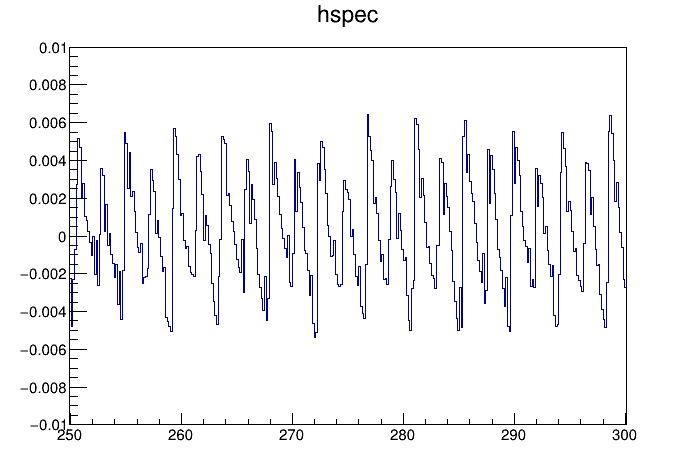

In [160]:
c = r.TCanvas()
hspec_resid_2.GetXaxis().SetRangeUser(250,300)
hspec_resid_2.GetYaxis().SetRangeUser(-0.01,0.01)
hspec_resid_2.Draw()
c.Draw()

residvec2 = []
for i in range(hspec_resid_2.GetNbinsX()):
    residvec2.append(hspec_resid_2.GetBinContent(i))

print(residvec2)

4700 699.9999999999999 -0.07446808510638298 699.9255319148936
0.14893617021276592 0.0014285714285714288
13.42857142857143 6.714285714285715


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


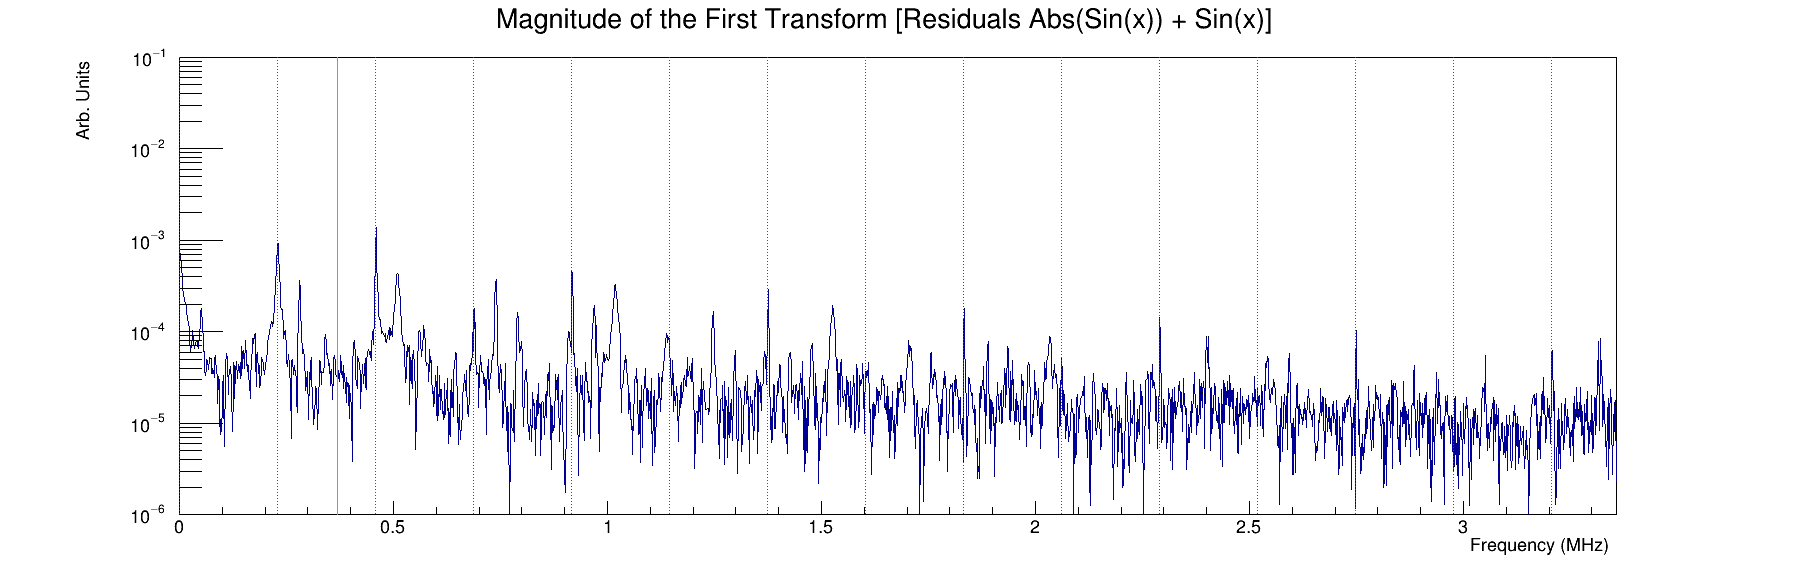

In [161]:
hxform_resid_2 = r.TH1D()
hxform_resid_2 = 0
r.TVirtualFFT.SetTransform(0)
hxform_resid_2 = hspec_resid_2.FFT(hxform_resid_2,"MAG P")
hxform_resid_2.SetTitle("Magnitude of the First Transform [Residuals Abs(Sin(x)) + Sin(x)]")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform_resid_2.GetEntries()
hxform_resid_2.Scale(1/normXform)
c2 = r.TCanvas("c2","c2",1800,600)
c2.cd()
#c2.SetLogy()
hxform_resid_2.GetXaxis().SetTitle("Frequency (MHz)")
hxform_resid_2.GetYaxis().SetTitle("Arb. Units")
hxform_resid_2.Draw("HIST P0 L")
c2.Draw()

Npart = hspec2.GetSize() - 2
minBinCenter = hspec2.GetXaxis().GetBinCenter(0)
maxBinCenter = hspec2.GetXaxis().GetBinCenter(Npart)

capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10.0,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = hxform_resid_2.GetSize() - 2
hxform_resid_2.SetBins(Npart,0,limmaxMHz)
hxform_resid_2.GetXaxis().SetRangeUser(0,limmaxMHz/2)

residuals5paramXform_resid_2 = hxform_resid_2.Clone()

hxform_resid_2.GetYaxis().SetRangeUser(0.000001,0.1)
cboline = r.TLine(0.37,0.000001,0.37,0.1)
cboline.SetLineColor(3)
cboline.Draw("SAME")
oalines = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines.append(oalinei)

c2.SetLogy()
c2.Draw()

---
### Comparison of the residuals FFT and the initial FFT

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


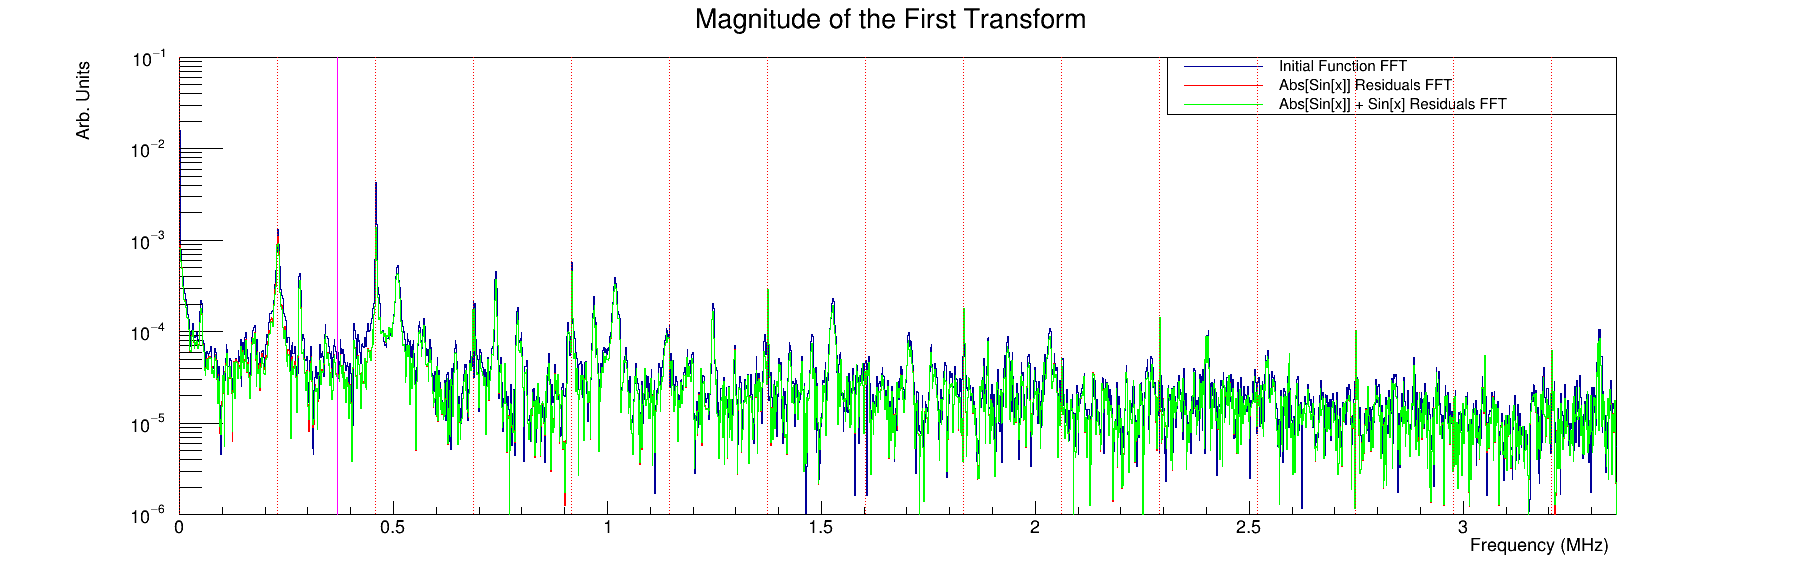

In [162]:
c2 = r.TCanvas("c2","c2",1800,600)
c2.cd()

hxform_resid.SetLineColor(2)
hxform_resid_2.SetLineColor(3)

hxform.Draw("HIST")
hxform_resid.Draw("HIST SAME")
hxform_resid_2.Draw("HIST SAME")

leg = r.TLegend(0.65,0.8,0.9,0.9)
leg.AddEntry(hxform ,"Initial Function FFT", "l")
leg.AddEntry(hxform_resid ,"Abs[Sin[x]] Residuals FFT", "l")
leg.AddEntry(hxform_resid_2 ,"Abs[Sin[x]] + Sin[x] Residuals FFT", "l")
leg.Draw()

cboline = r.TLine(0.37,0.000001,0.37,0.1)
cboline.SetLineColor(6)
cboline.Draw("SAME")
oalines = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines.append(oalinei)

c2.SetLogy()
c2.Draw()

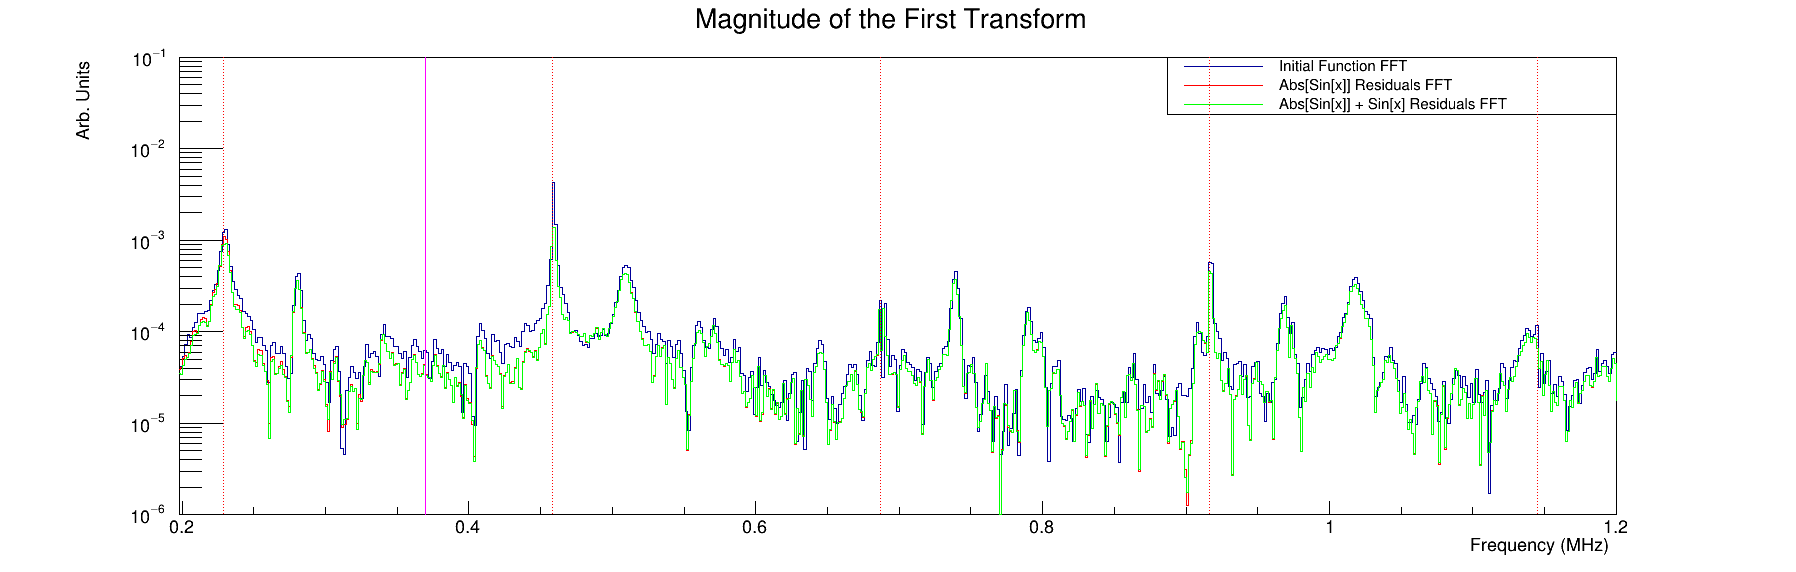

In [163]:
hxform.GetXaxis().SetRangeUser(0.2,1.2)
c2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


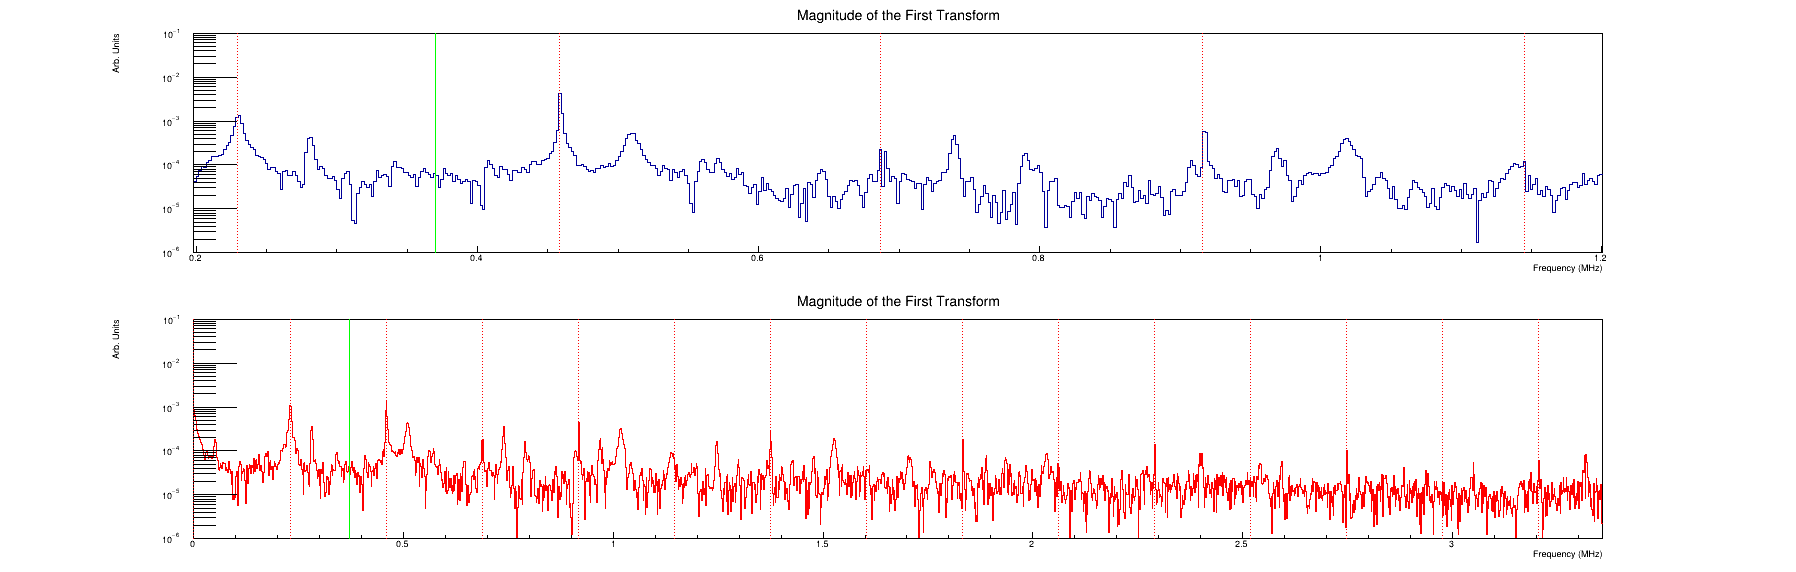

In [164]:
c2 = r.TCanvas("c2","c2",1800,600)
c2.Divide(1,2)
c2.cd(1)

hxform_resid.SetLineColor(2)

hxform.Draw("HIST")

cboline = r.TLine(0.37,0.000001,0.37,0.1)
cboline.SetLineColor(3)
cboline.Draw("SAME")
oalines = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines.append(oalinei)
r.gPad.SetLogy()

c2.cd(2)
hxform_resid.Draw("HIST")
cboline.Draw("SAME")
oalines1 = []
for i in range(15):
    oalinei = r.TLine(0.229*i,0.000001,0.229*i,0.1)
    oalinei.SetLineColor(2)
    oalinei.SetLineStyle(3)
    oalinei.Draw()
    oalines1.append(oalinei)

r.gPad.SetLogy()
c2.Draw()